In [191]:
# Import standard libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import statsmodels.api as sm
import warnings 
warnings.filterwarnings('ignore') # mute warning messages

# Import specific objects
from ISLP.models import (ModelSpec as MS,
                         summarize)
from ISLP import load_data
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

In [164]:
# Specify the path to the CSV file
file_path = 'c:\\USC\\team_project\\data\\raw\\credit_risk_dataset.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
print(df.head())

   person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                           3  


In [165]:
print("Number of missing values per column:")
print(df.isnull().sum())

Number of missing values per column:
person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64


In [166]:
# Remove rows with any missing values
df.dropna(inplace=True)

# Remove Duplicates
df.drop_duplicates(inplace=True)

# Remove outliers based on condition (e.g., values greater than a threshold)
df = df[df['person_emp_length'] < 100]  # person with employment length in years over 50

# Rename Columns
df.rename(columns={'cb_person_cred_hist_length': 'person_credit_history'}, inplace=True)
df.rename(columns={'cb_person_default_on_file': 'person_credit_default'}, inplace=True)

# Convert column values to specific type (e.g., 'int', 'float', 'str')
df['person_credit_default'] = df['person_credit_default'].map({'Y': 1, 'N': 0}) # person credit default value from Y/N to 0 or 1

# Display the cleaned DataFrame
print("Cleaned DataFrame:")
print(df.head())

# Save the cleaned DataFrame to a new CSV file in processed folder
processed_file_path = 'c:\\USC\\team_project\\data\\processed\\credit_risk_dataset_processed.csv'
df.to_csv(processed_file_path, index=False)

Cleaned DataFrame:
   person_age  person_income person_home_ownership  person_emp_length  \
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   
5          21           9900                   OWN                2.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   
5     VENTURE          A       2500           7.14            1   

   loan_percent_income  person_credit_default  person_credit_history  
1                 0.10                      0                      2

In [53]:
df.describe().iloc[:,:]

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,person_credit_default,person_credit_history
count,28499.000000,2.849900e+04,28499.000000,28499.000000,28499.000000,28499.000000,28499.000000,28499.000000,28499.000000
mean,27.739114,6.665028e+04,4.781852,9657.280957,11.045368,0.217095,0.169504,0.178568,5.800660
std,6.316170,6.237378e+04,4.037940,6327.749846,3.230617,0.412275,0.106384,0.382997,4.042247
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,0.000000,2.000000
25%,23.000000,3.949000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,0.000000,3.000000
50%,26.000000,5.600000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,0.000000,4.000000
75%,30.000000,8.000000e+04,7.000000,12500.000000,13.480000,0.000000,0.230000,0.000000,8.000000
max,144.000000,6.000000e+06,41.000000,35000.000000,23.220000,1.000000,0.830000,1.000000,30.000000


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28499 entries, 1 to 32580
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   person_age             28499 non-null  int64  
 1   person_income          28499 non-null  int64  
 2   person_home_ownership  28499 non-null  object 
 3   person_emp_length      28499 non-null  float64
 4   loan_intent            28499 non-null  object 
 5   loan_grade             28499 non-null  object 
 6   loan_amnt              28499 non-null  int64  
 7   loan_int_rate          28499 non-null  float64
 8   loan_status            28499 non-null  int64  
 9   loan_percent_income    28499 non-null  float64
 10  person_credit_default  28499 non-null  int64  
 11  person_credit_history  28499 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 2.8+ MB


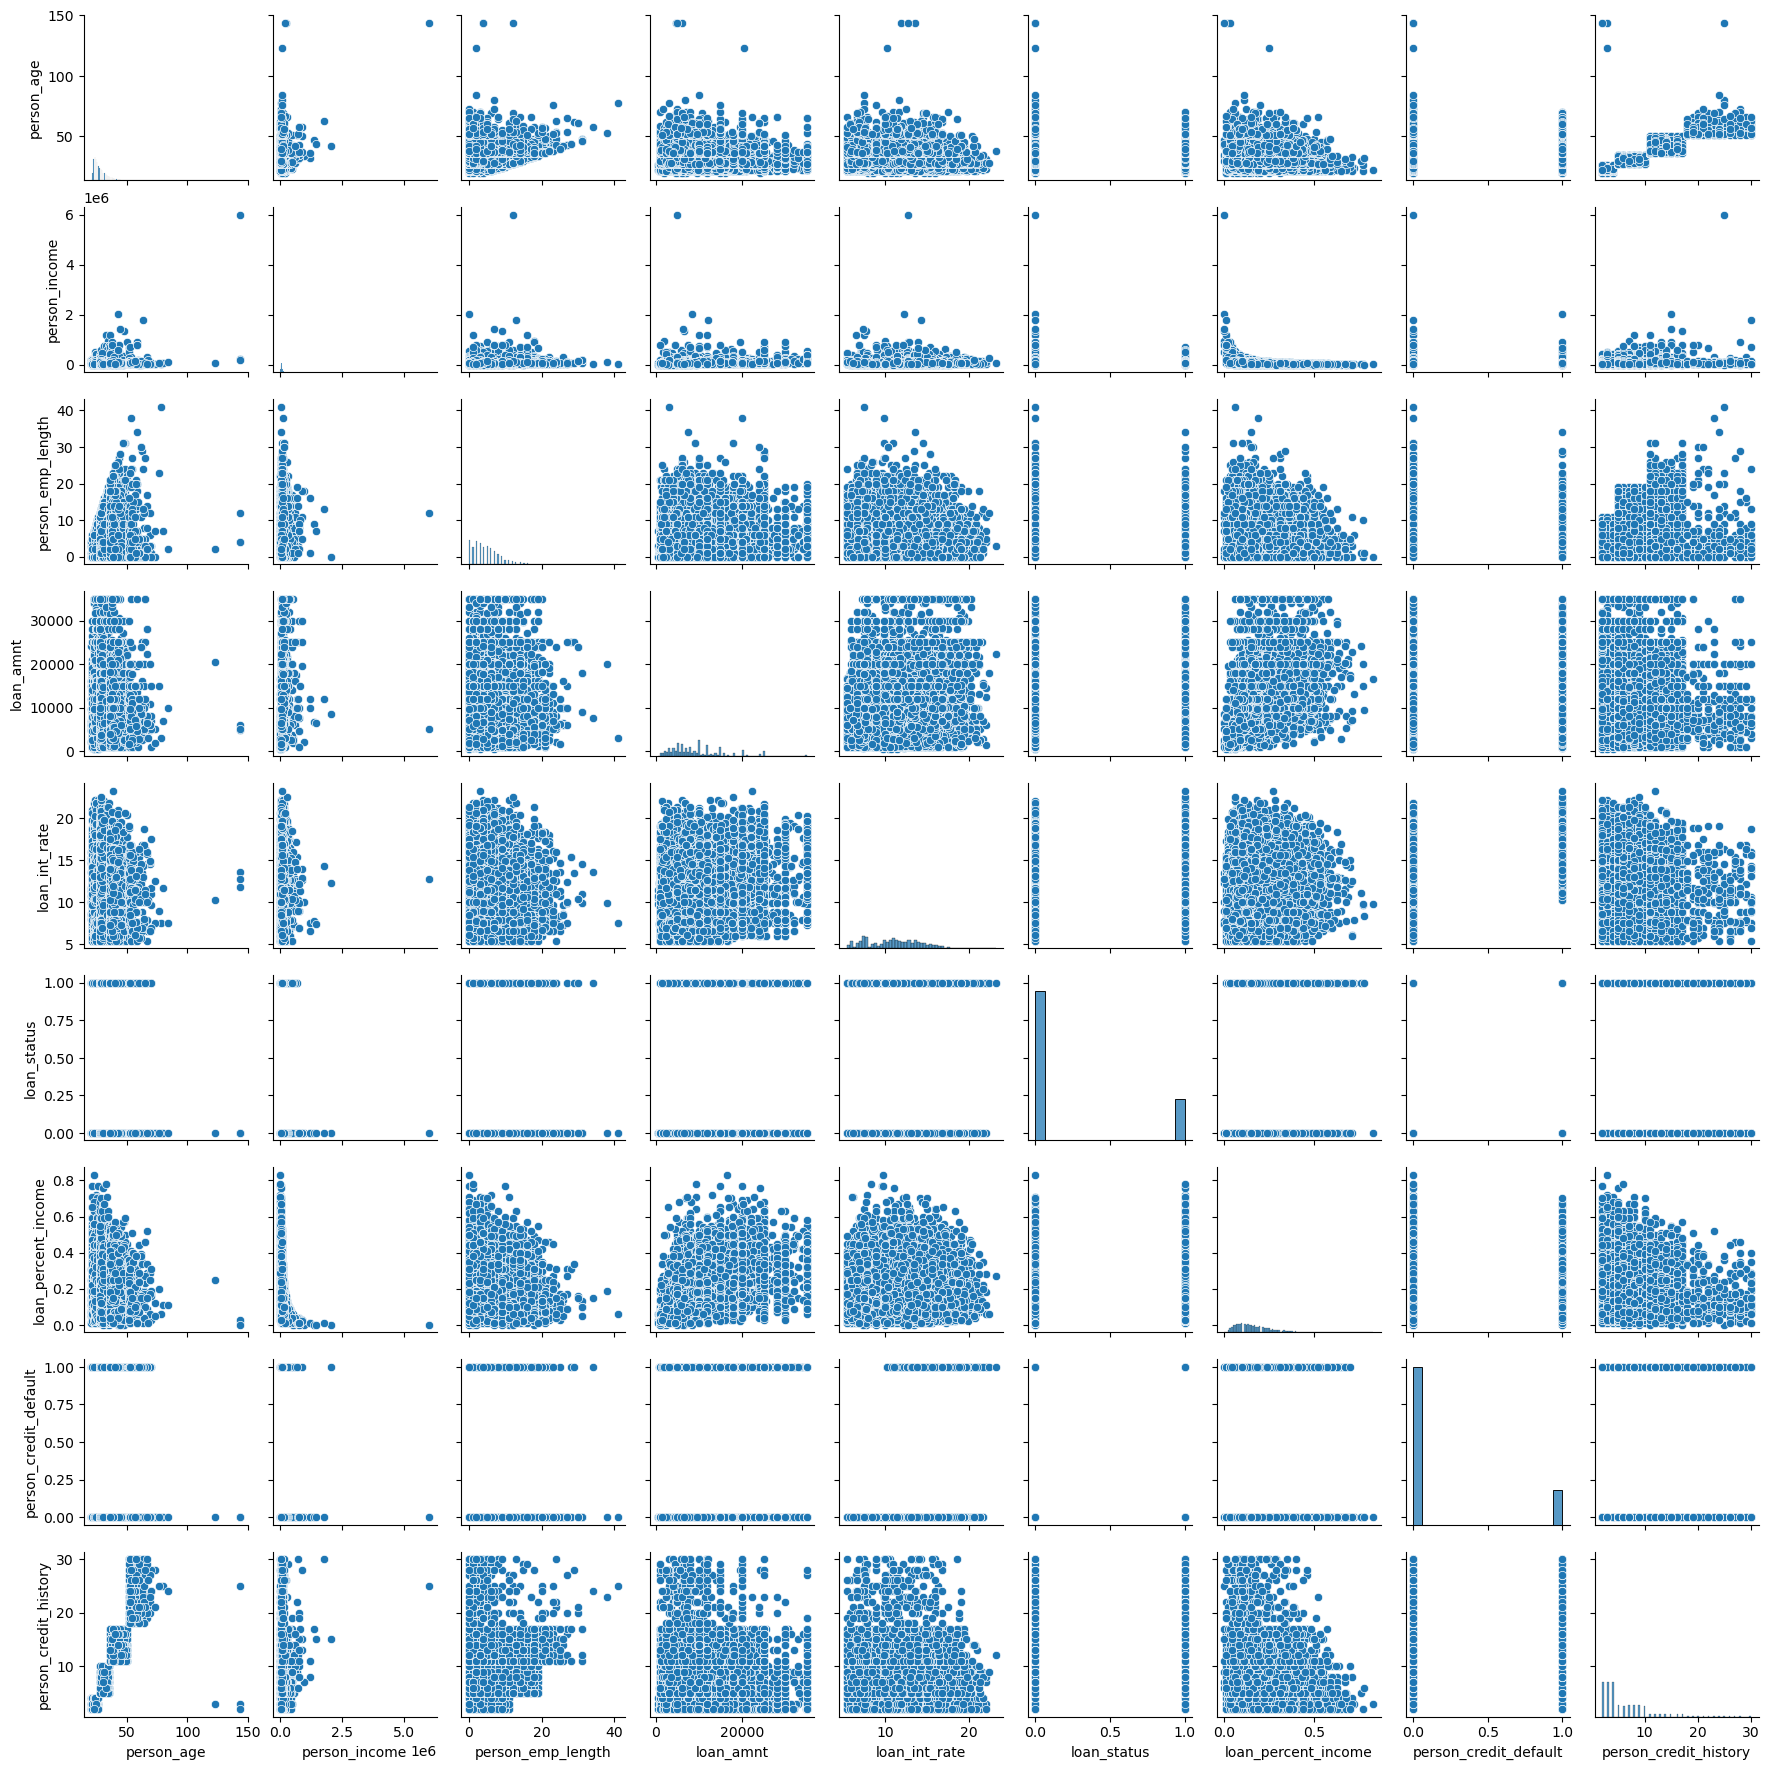

In [22]:
sns.pairplot(df, height=2.)

plt.show()

In [167]:
# Separating categorical and numerical variables

categorical_features = df.select_dtypes(include=['object']).columns
numerical_features = df.select_dtypes(include=[np.number]).columns

print("\nCategorical Variables:", categorical_features)
print("Numeric Variables:", numerical_features)


Categorical Variables: Index(['person_home_ownership', 'loan_intent', 'loan_grade'], dtype='object')
Numeric Variables: Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'person_credit_default', 'person_credit_history'],
      dtype='object')


In [168]:
# Analysis of categorical variables

for col in categorical_features:
    print(f"\nDistribution of categorical variable {col}:")
    print(df[col].value_counts())


Distribution of categorical variable person_home_ownership:
person_home_ownership
RENT        14497
MORTGAGE    11735
OWN          2174
OTHER          93
Name: count, dtype: int64

Distribution of categorical variable loan_intent:
loan_intent
EDUCATION            5670
MEDICAL              5269
VENTURE              4968
PERSONAL             4858
DEBTCONSOLIDATION    4547
HOMEIMPROVEMENT      3187
Name: count, dtype: int64

Distribution of categorical variable loan_grade:
loan_grade
A    9344
B    9094
C    5682
D    3242
E     869
F     209
G      59
Name: count, dtype: int64


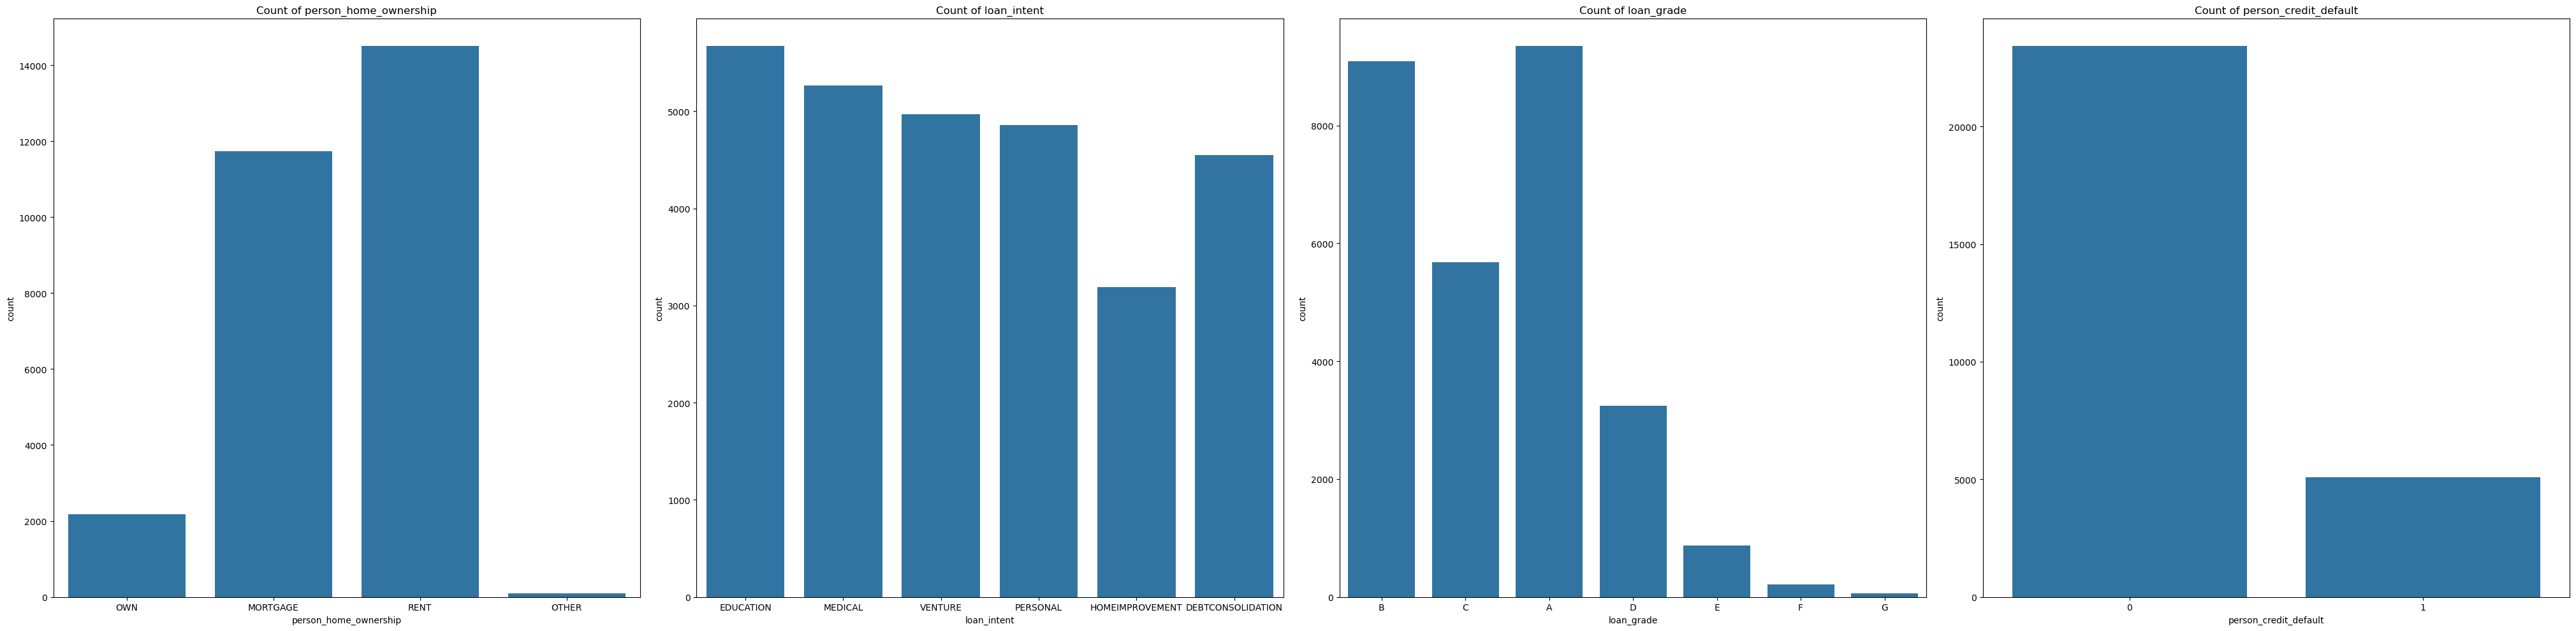

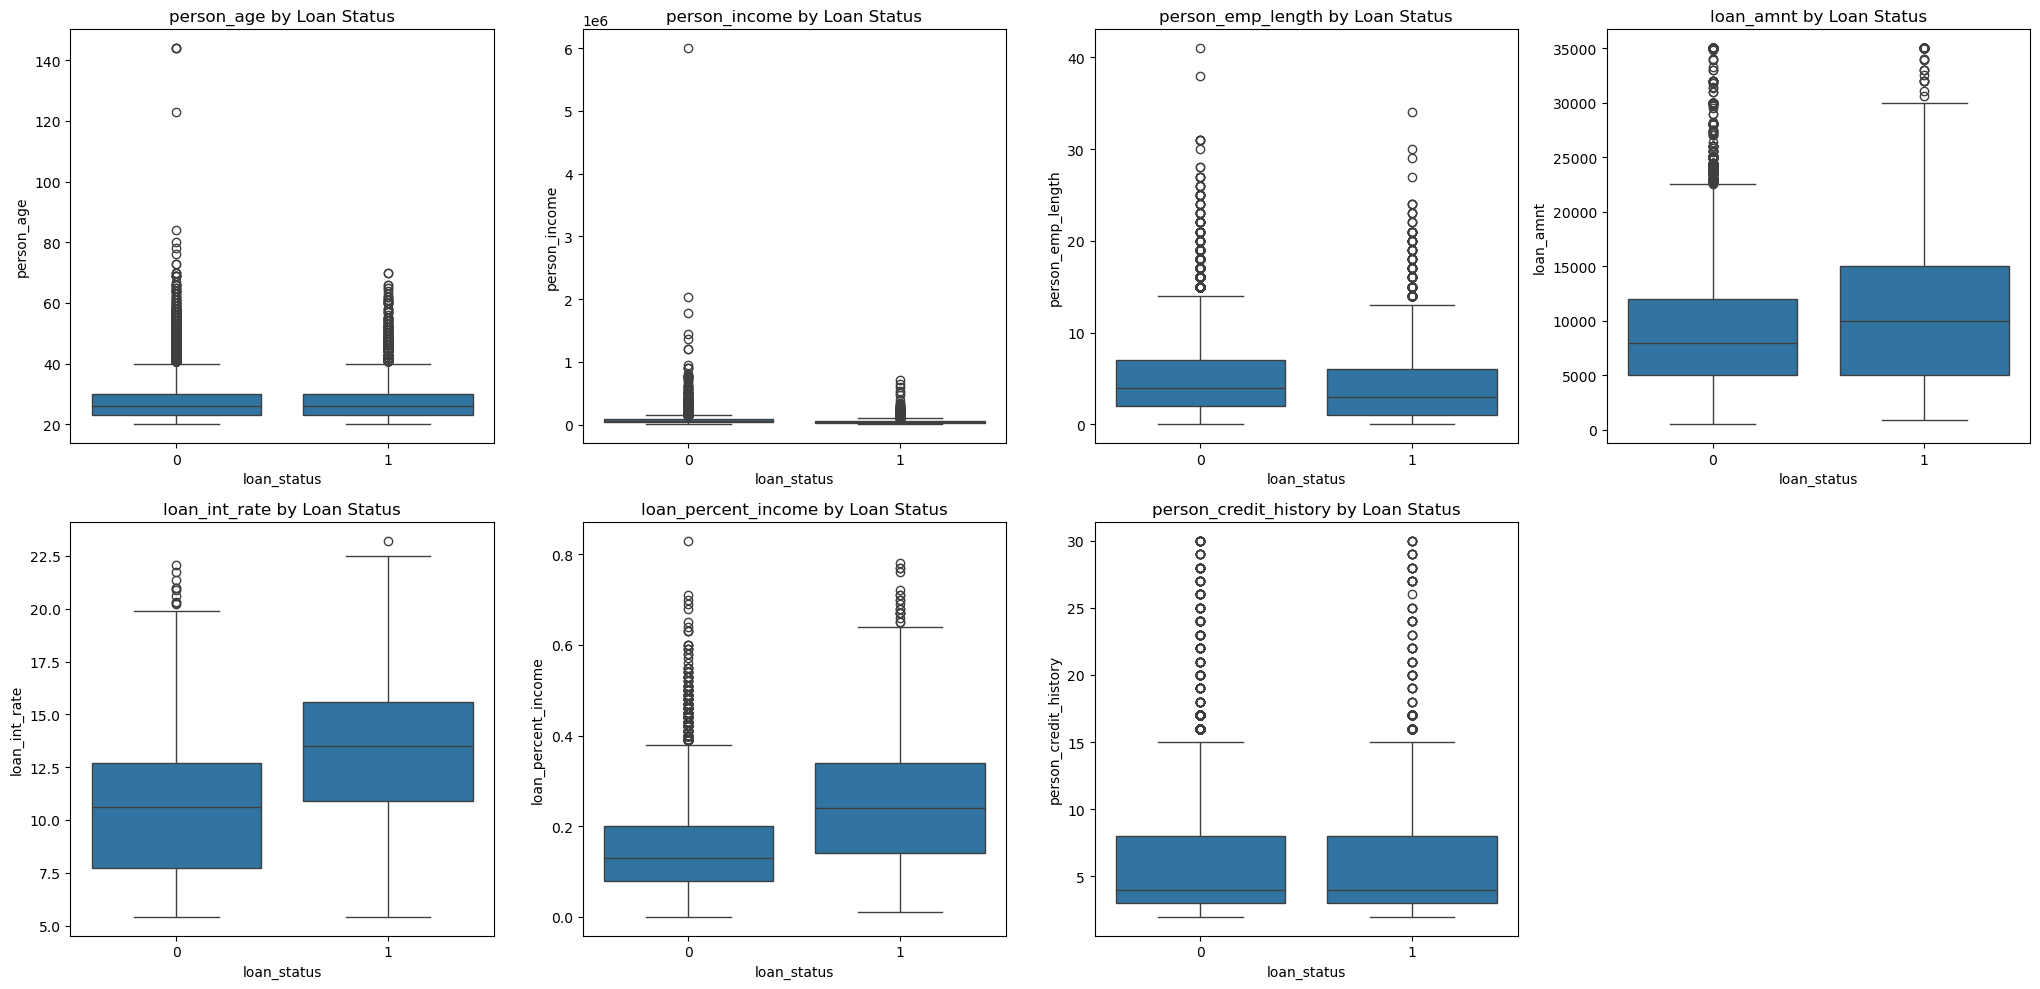

In [57]:
# Counting categorical variables
plt.figure(figsize=(40.5, 10))
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade','person_credit_default']
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(1, 4, i)
    sns.countplot(x=df[col])
    plt.title(f'Count of {col}')
    plt.grid(False)
    plt.tight_layout()
plt.show()

# These histograms illustrate the distribution of values for each categorical variable 

# Comparison of distributions
numerical_cols = ['person_age', 'person_income','person_emp_length', 'loan_amnt',
                  'loan_int_rate', 'loan_percent_income',
                  'person_credit_history']

# Boxplots chart
print()
print()
plt.figure(figsize=(20.5, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(x='loan_status', y=col, data=df)
    plt.title(f'{col} by Loan Status')
    plt.grid(False)
plt.tight_layout()
plt.show()

# Box plots show that Loan amount, loan interest rate, loan percent income influence loan status the presence of outliers 
# which have been retained to ensure our model remains robust and can handle a wide range of conditions. 


Distribution of response variable 'Loan status':
loan_status
0    22312
1     6187
Name: count, dtype: int64


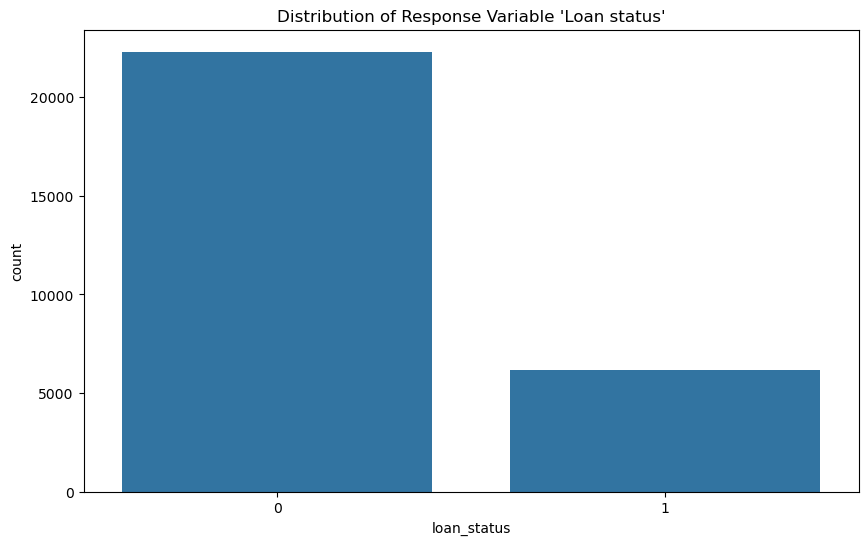

In [58]:
# Analysis of response variable 'Loan status'
print("\nDistribution of response variable 'Loan status':")
print(df['loan_status'].value_counts())
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='loan_status')
plt.title("Distribution of Response Variable 'Loan status'")
plt.grid(False)
plt.show()

Loan status represents cases of credit approval, indicating whether the credit was approved (yes) or not (no).

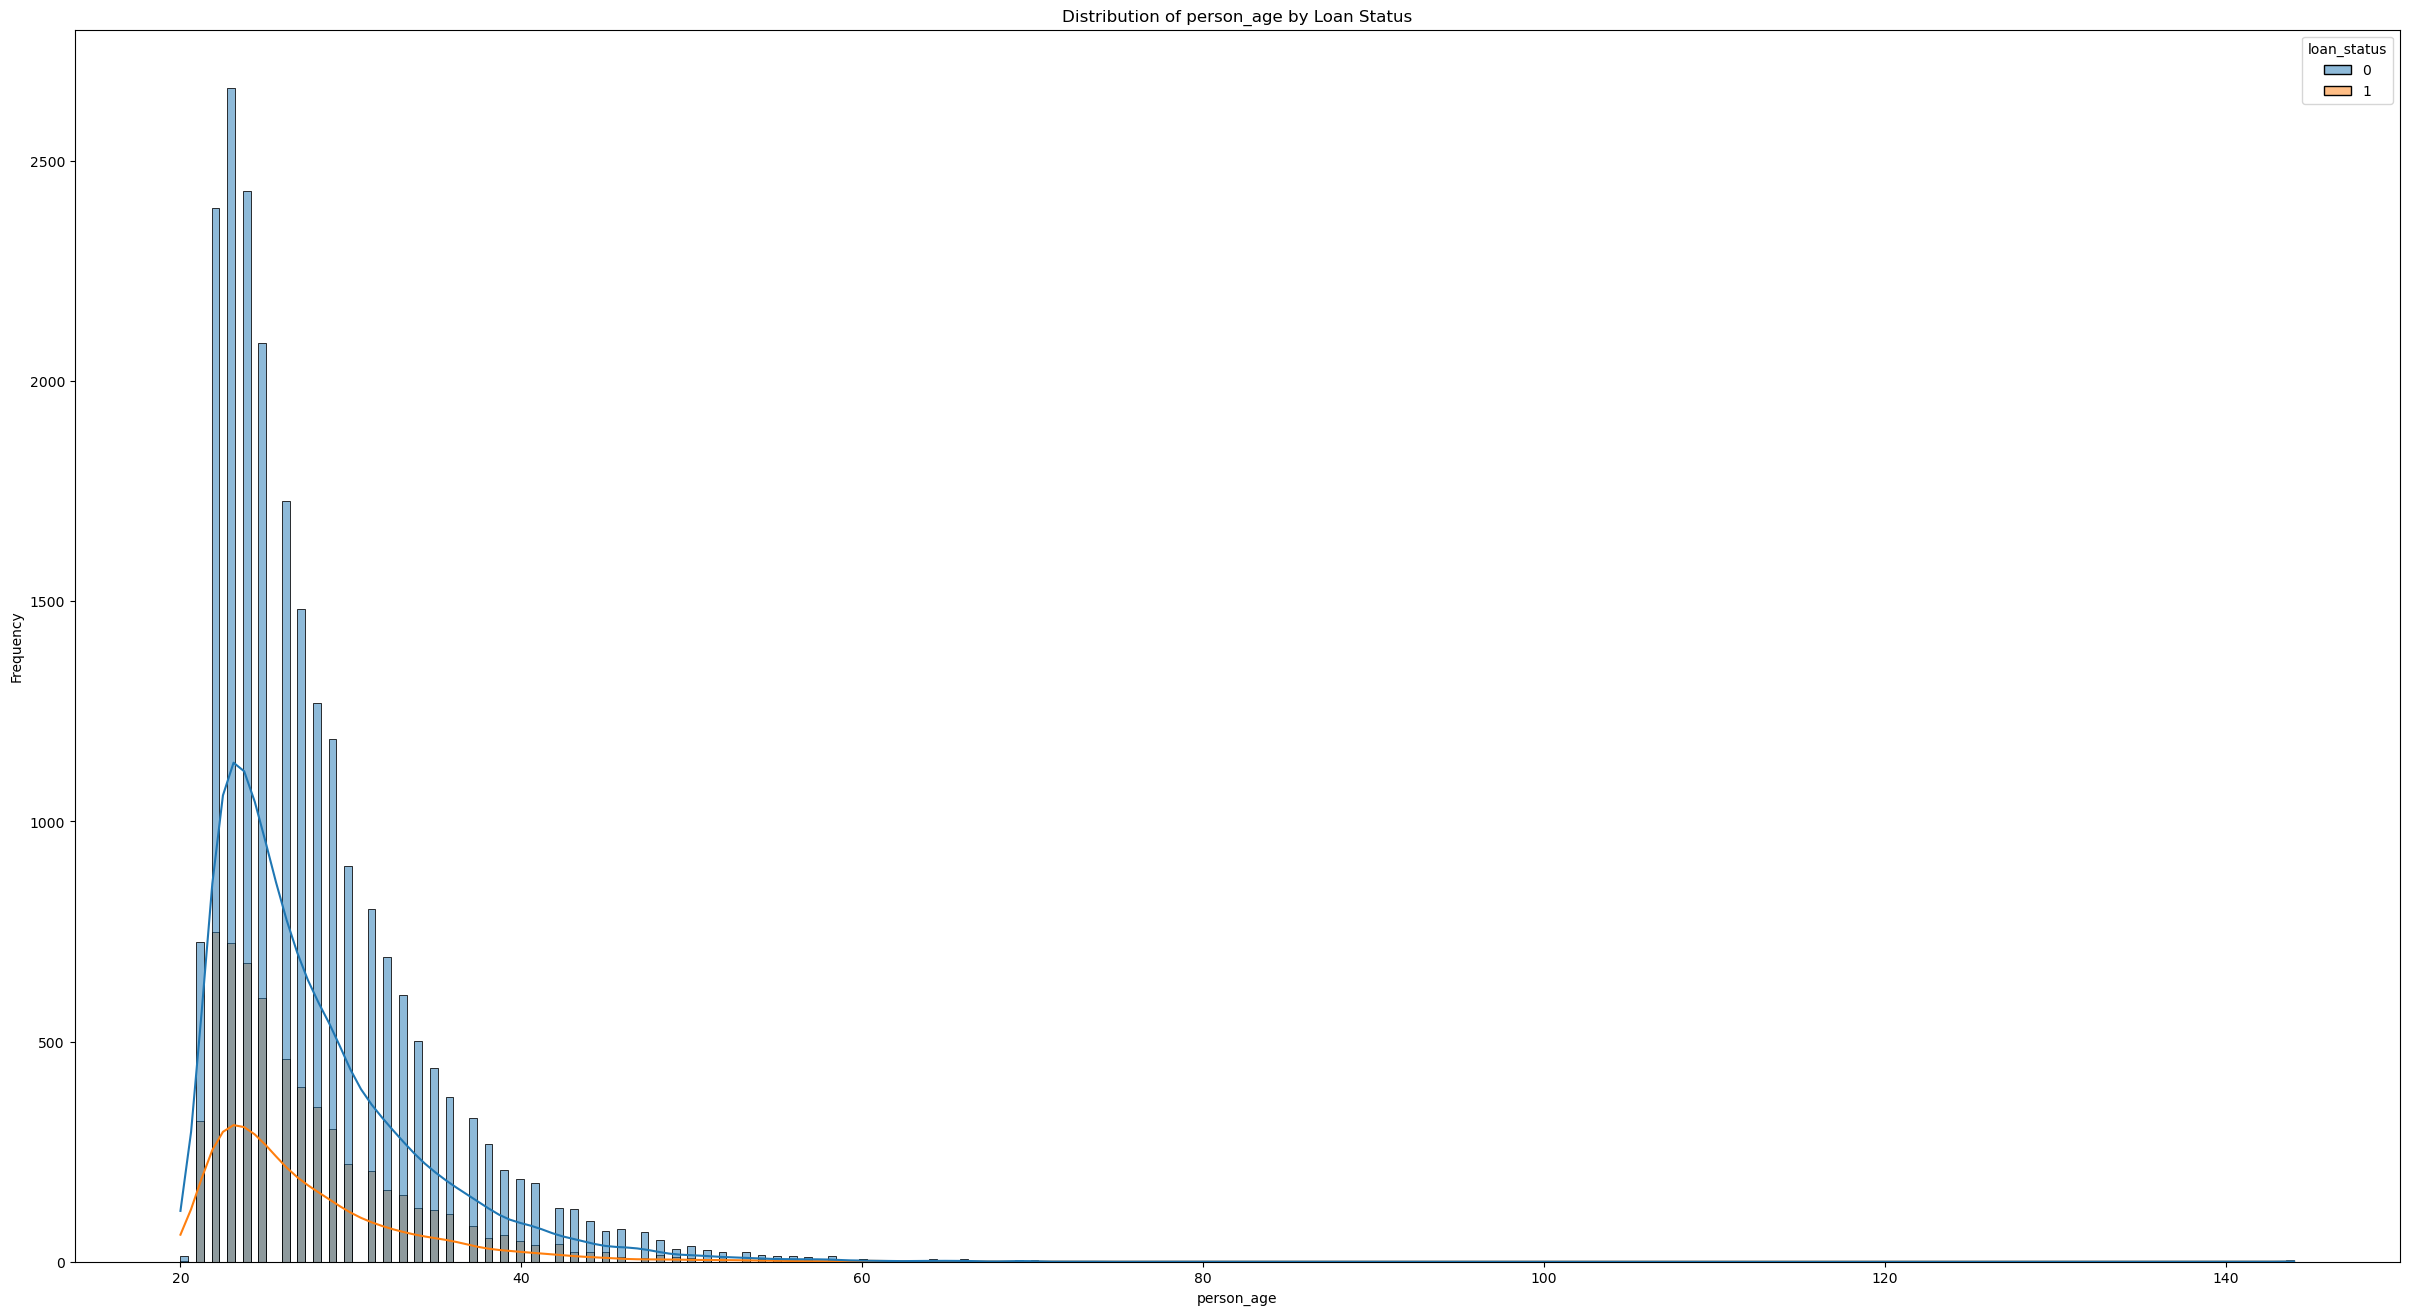

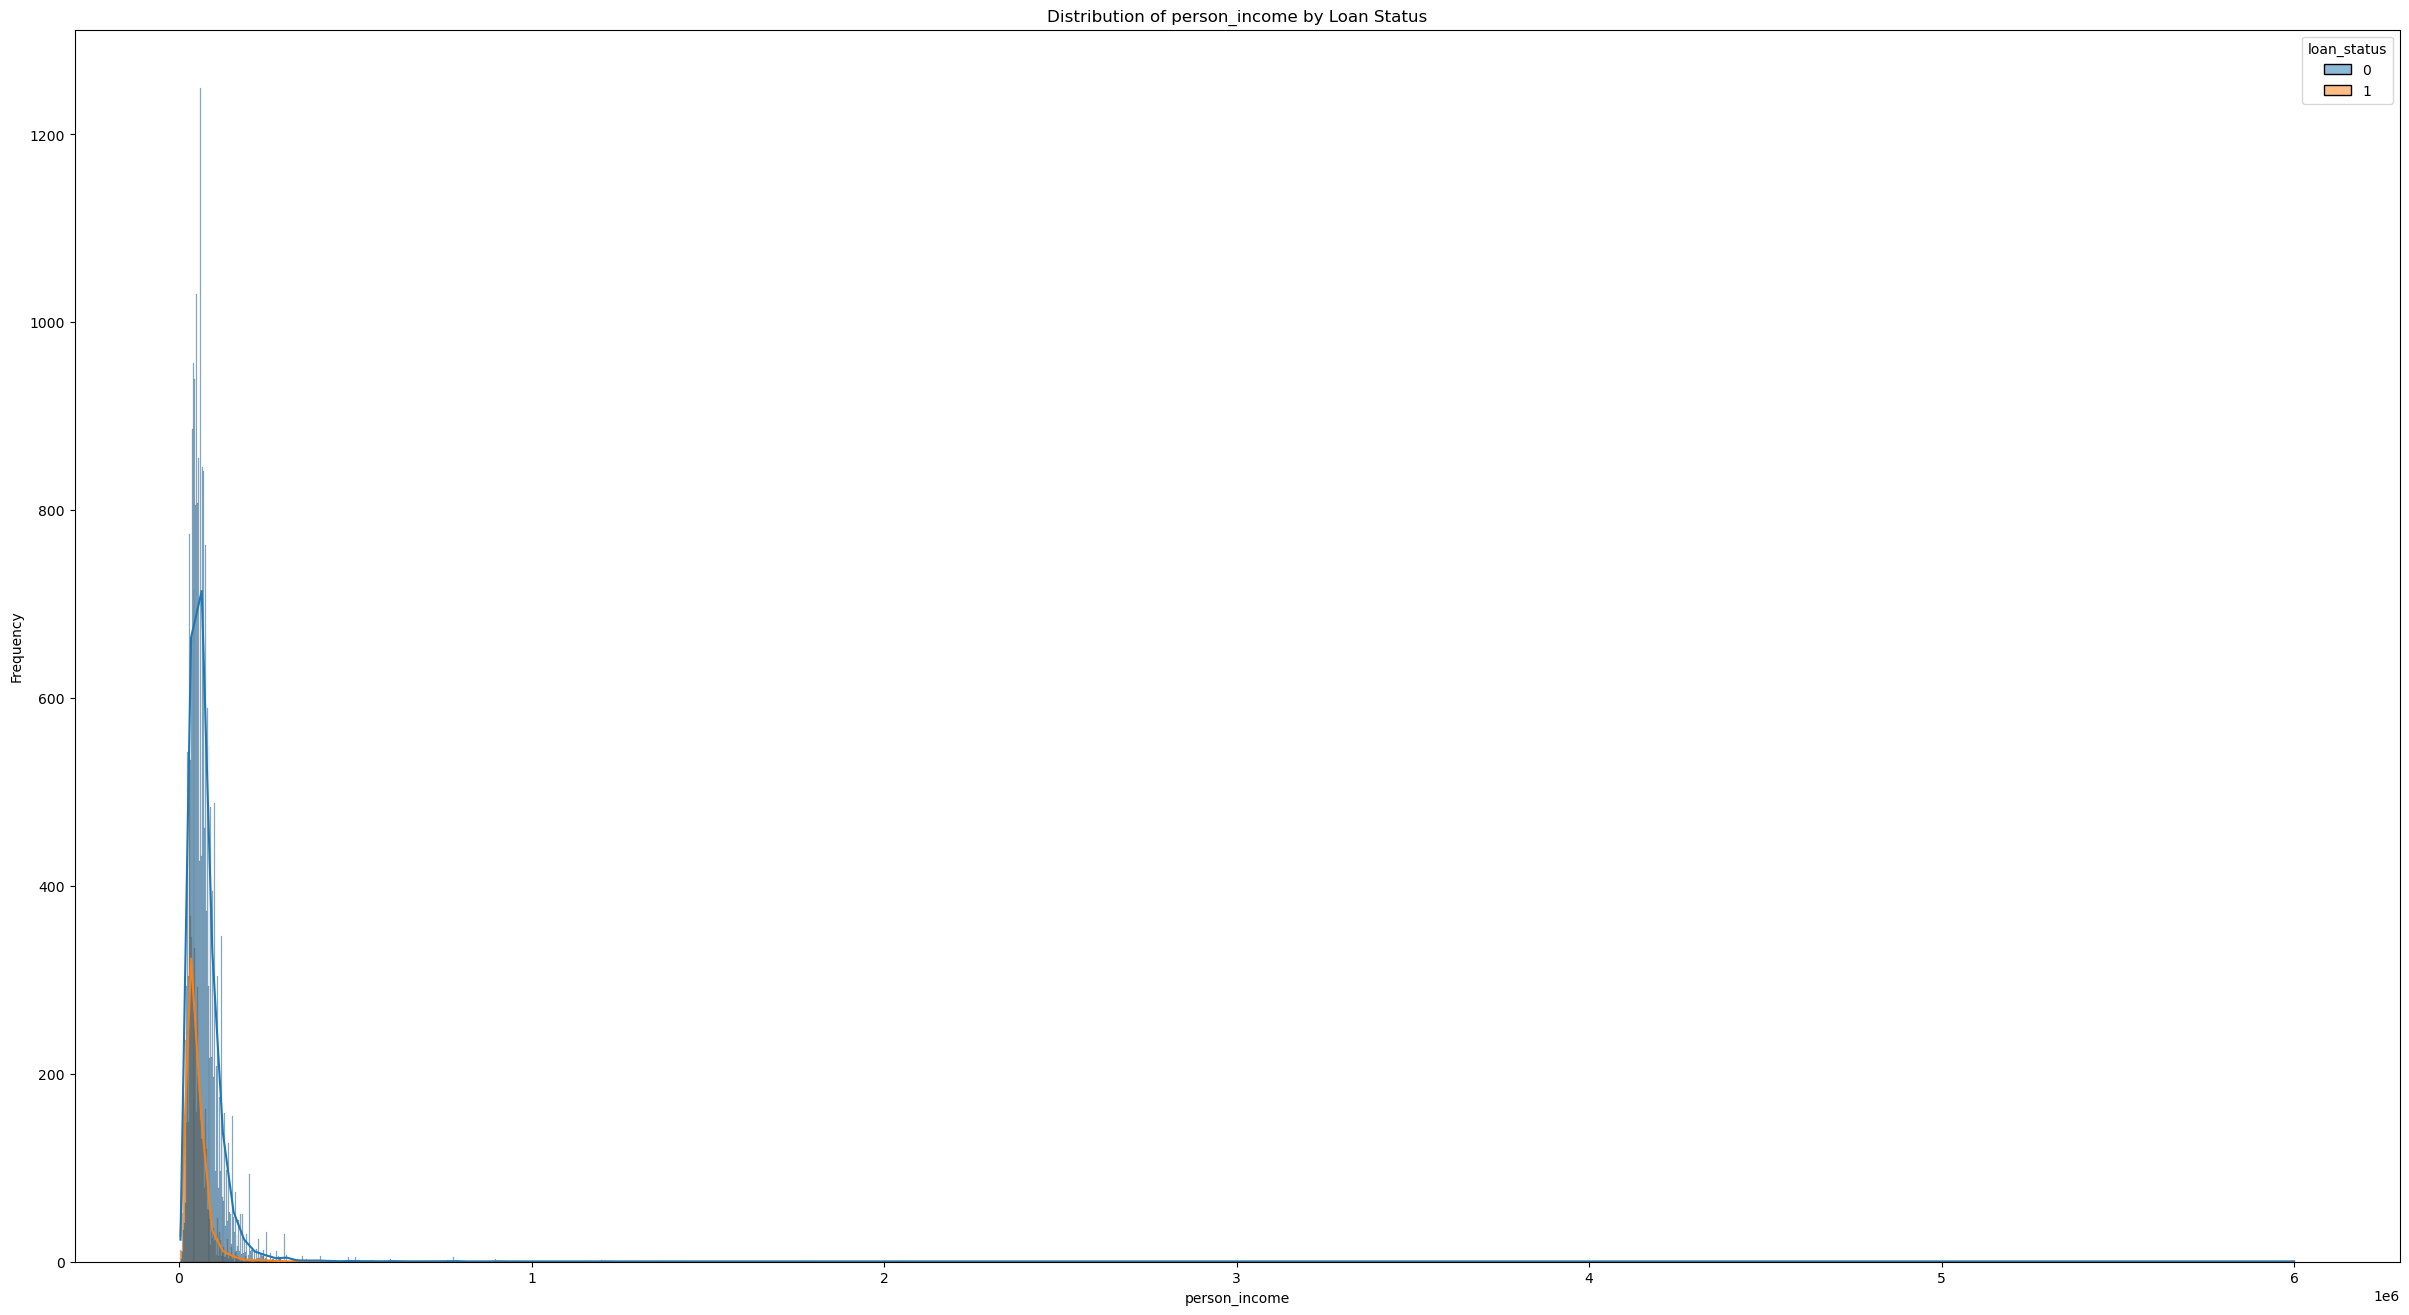

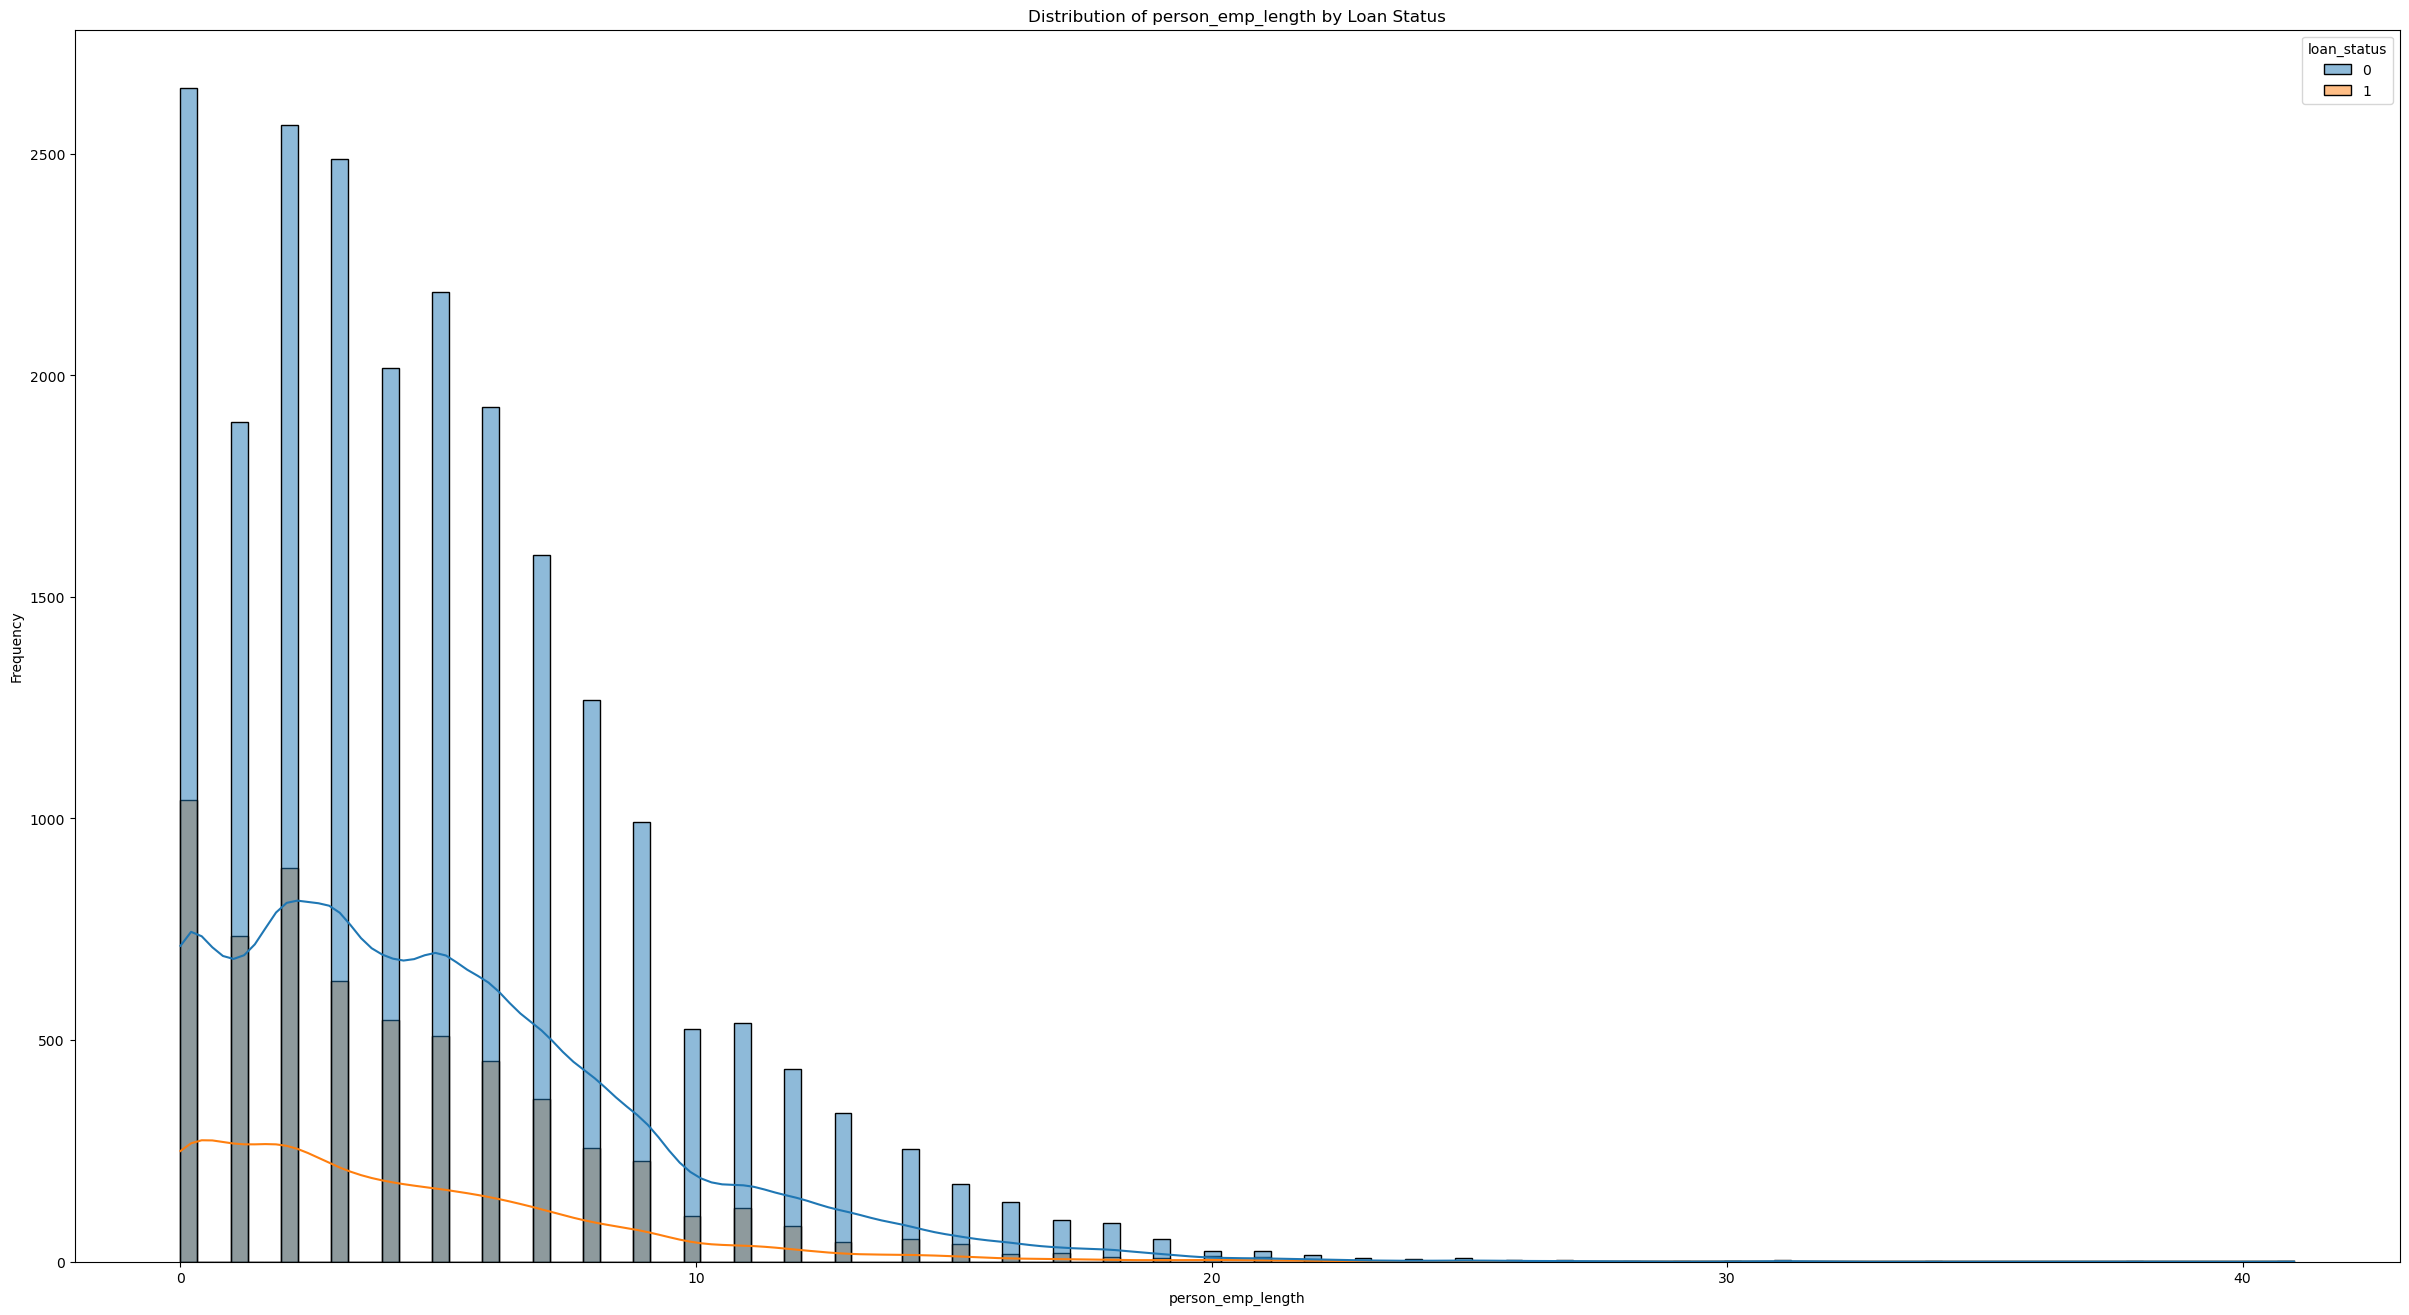

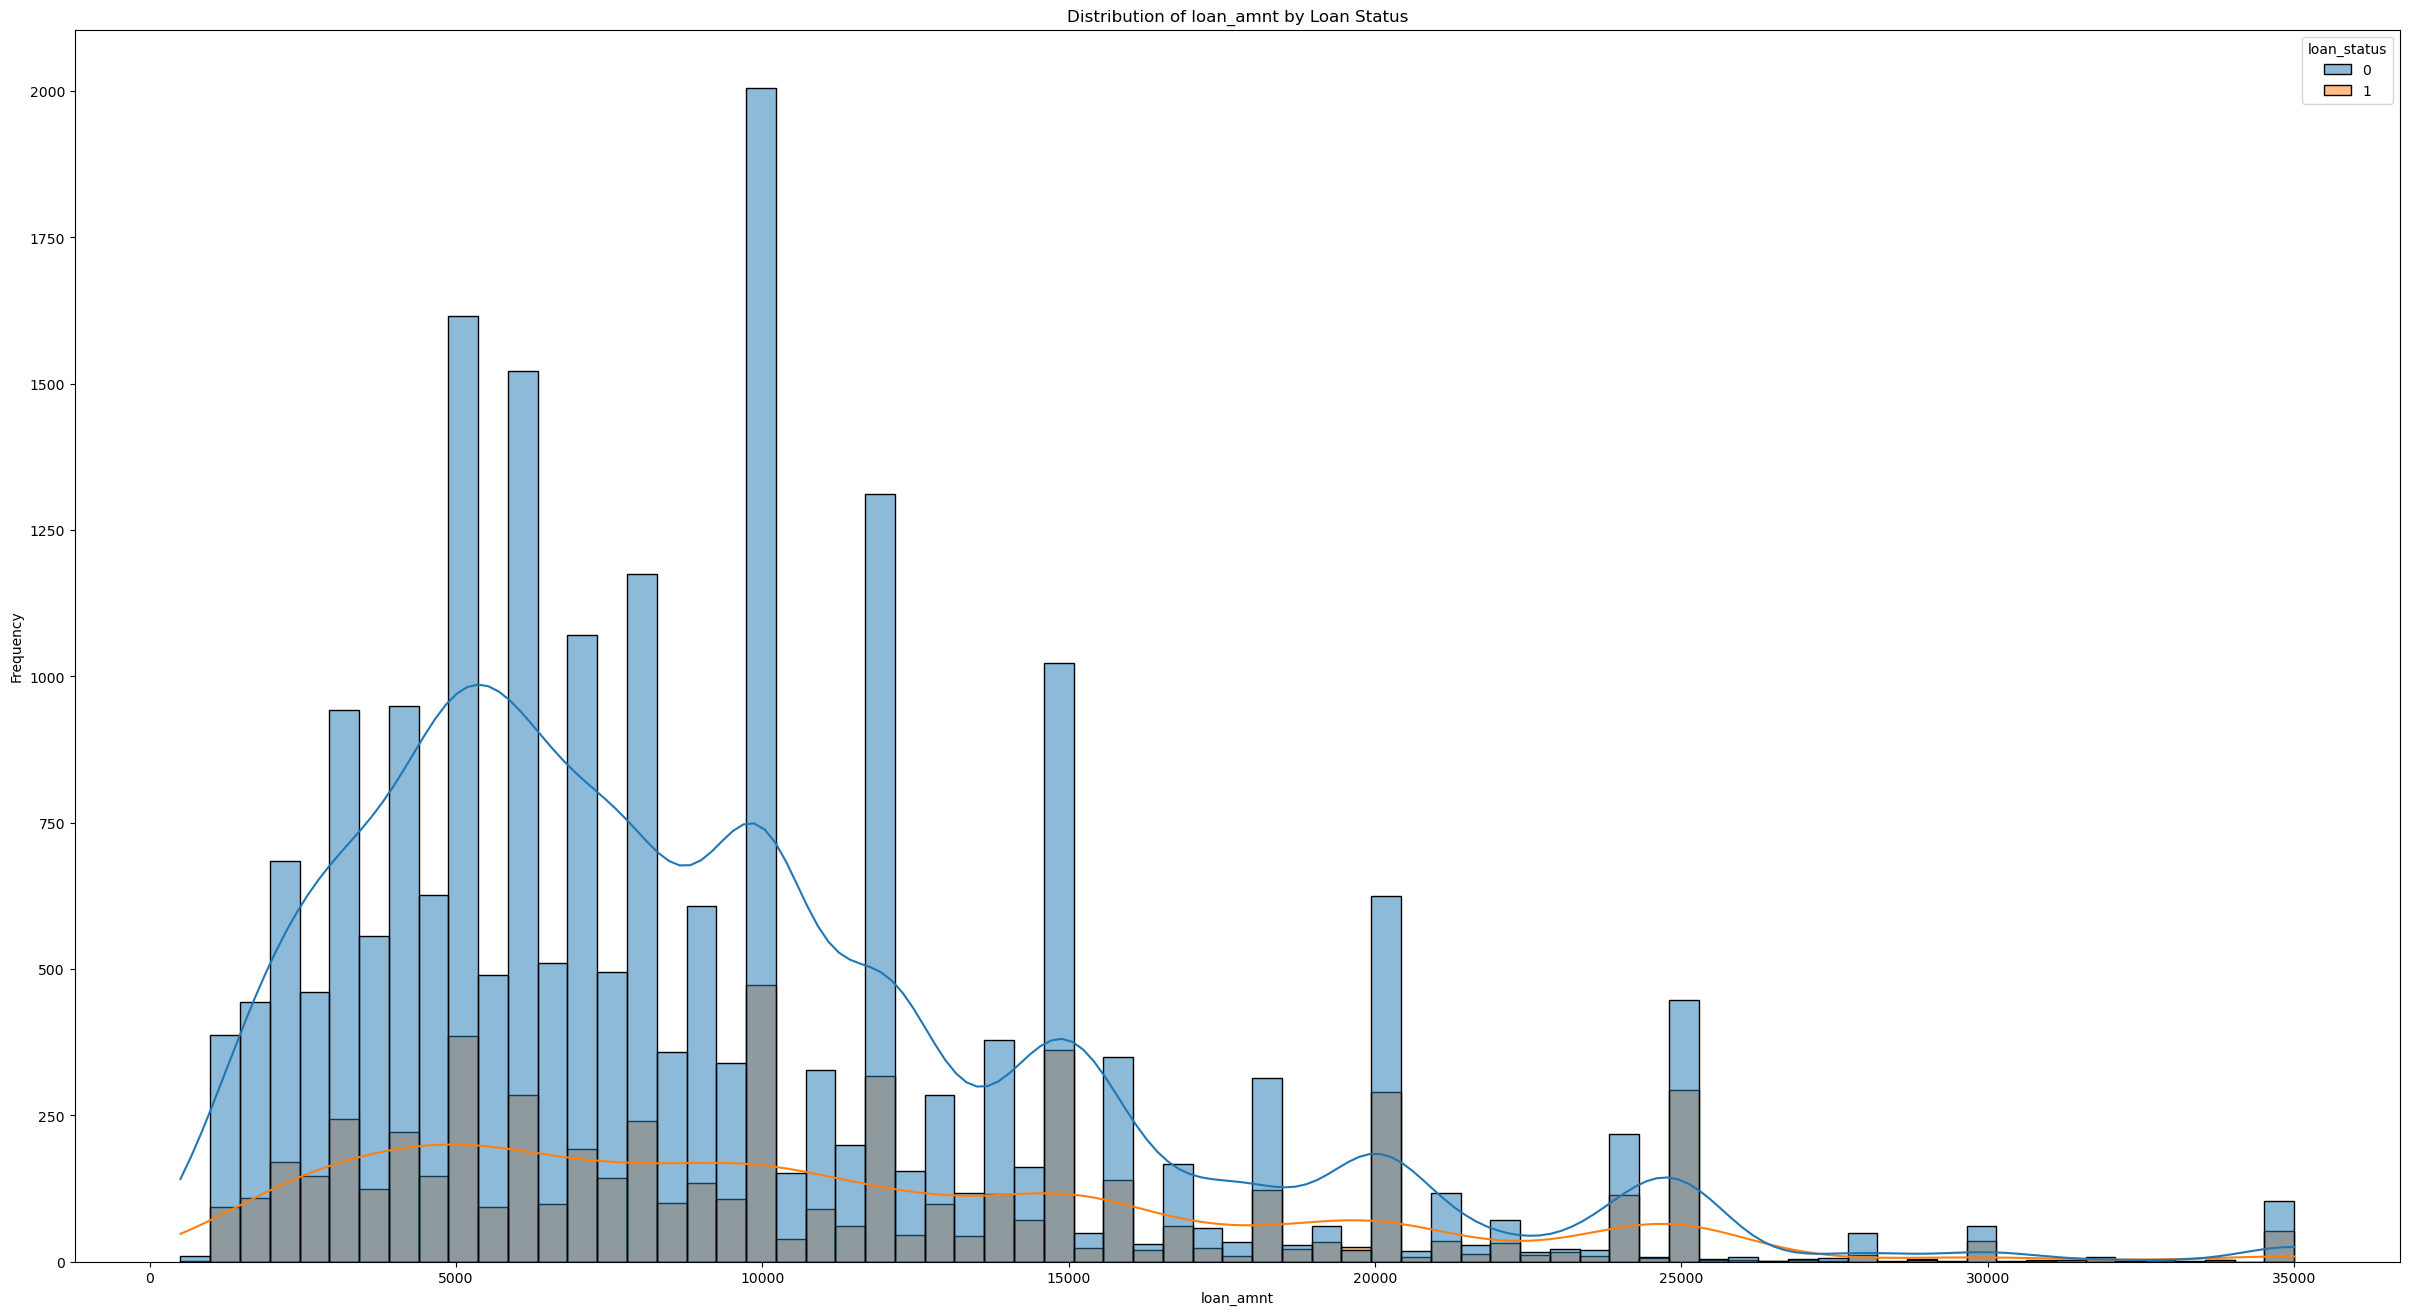

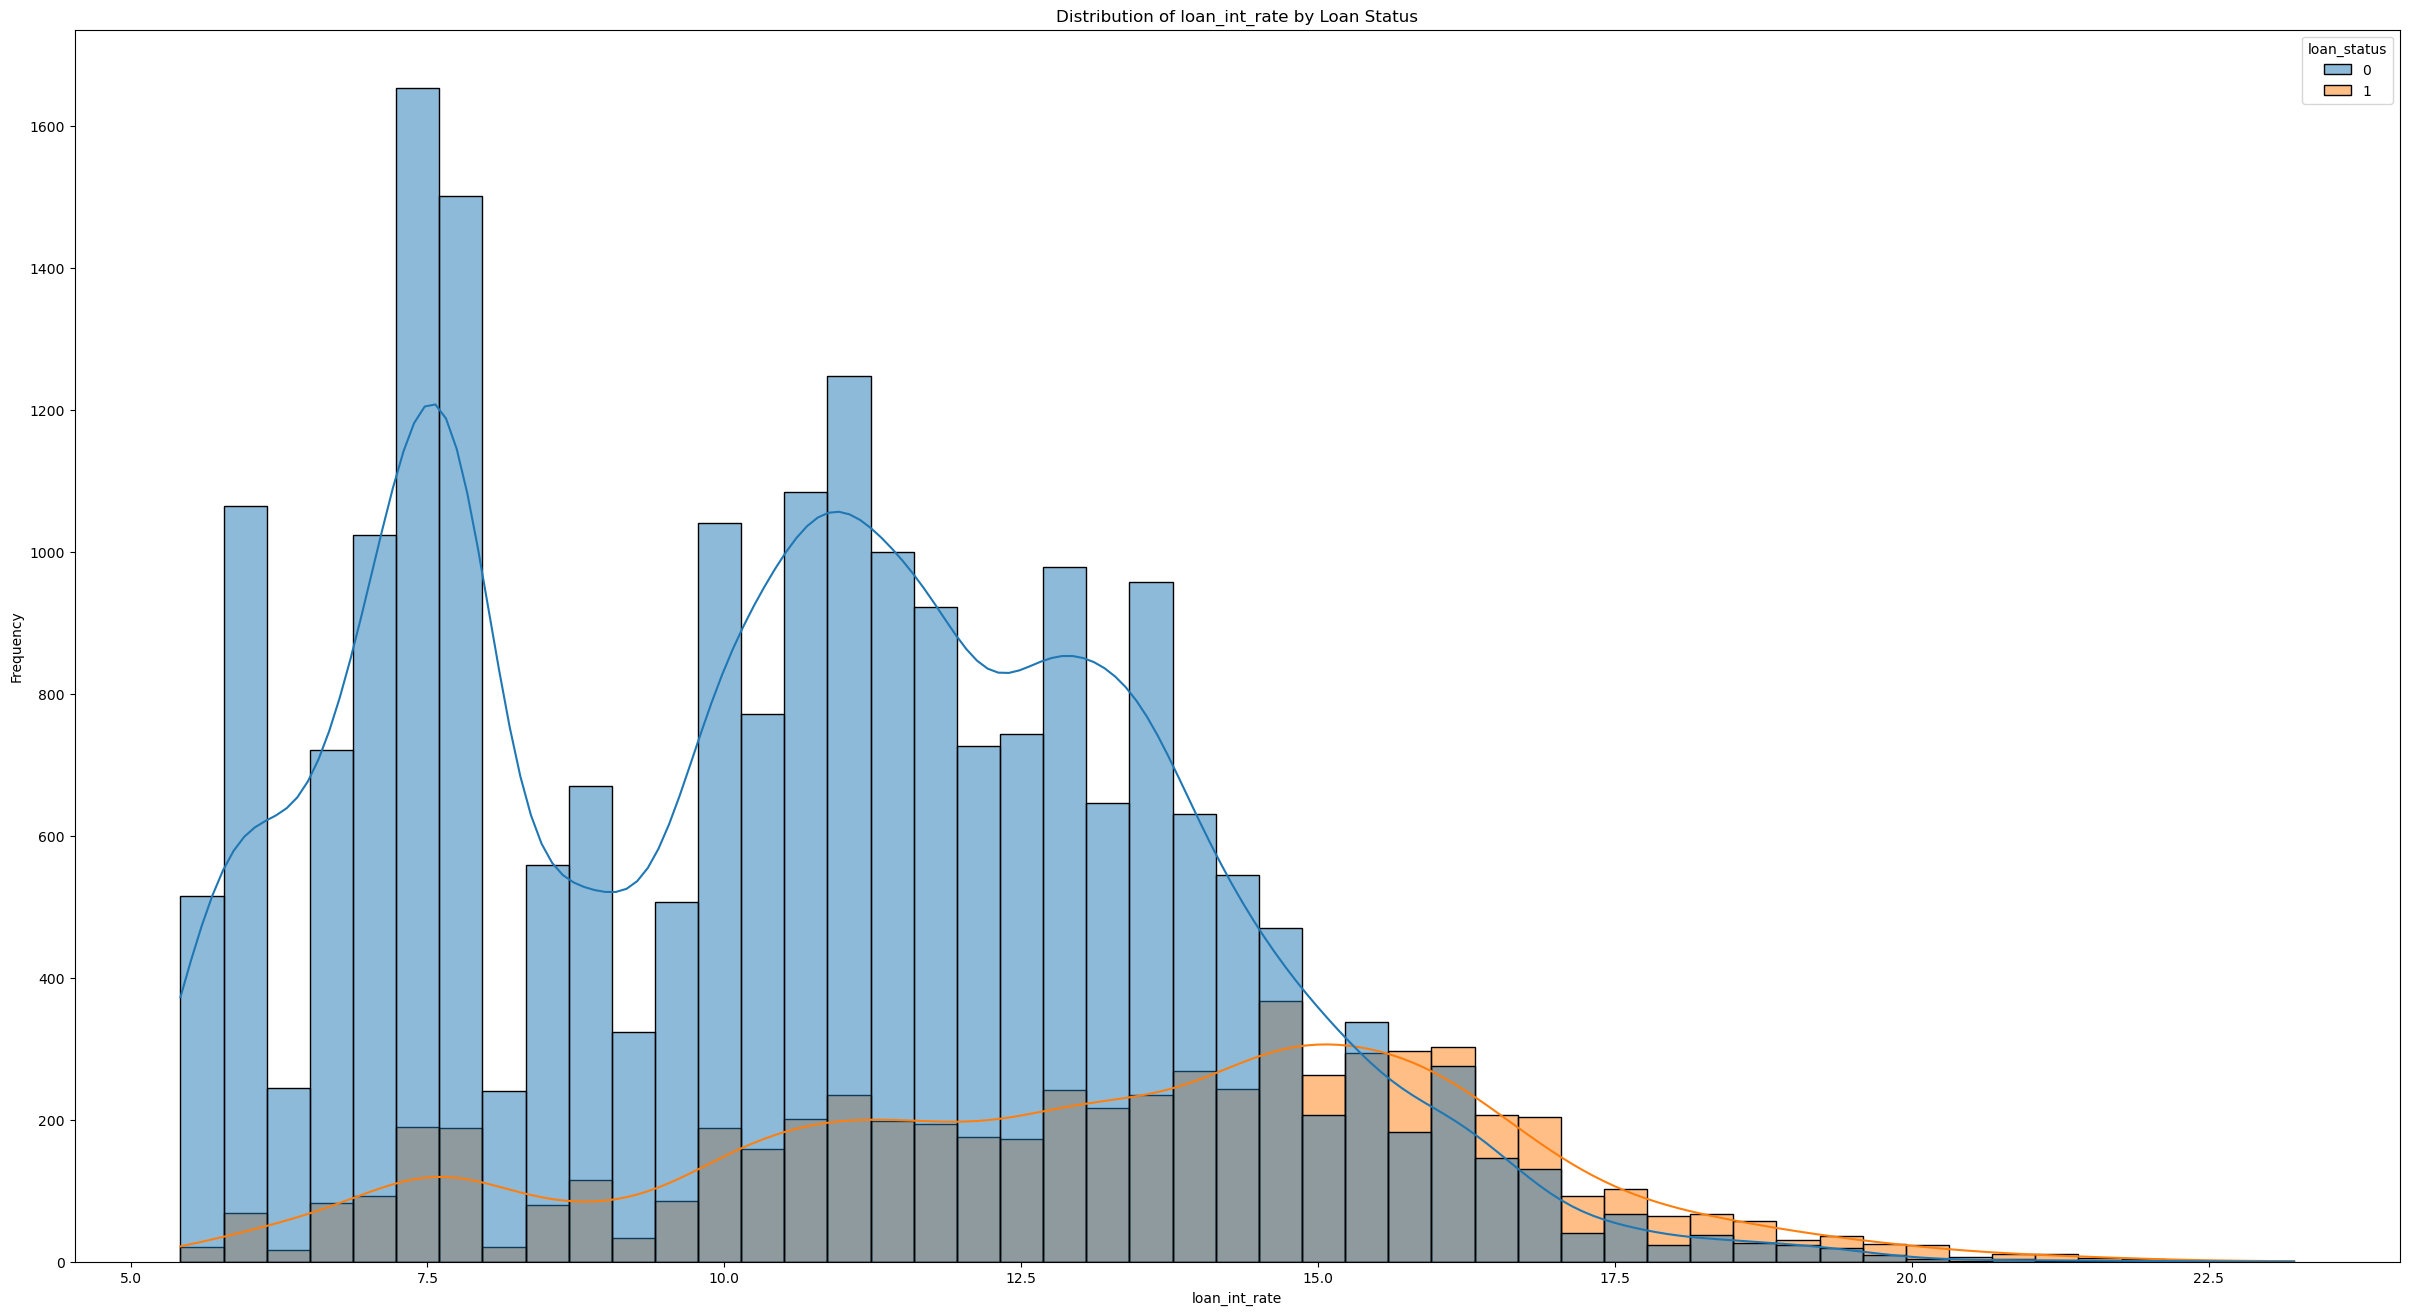

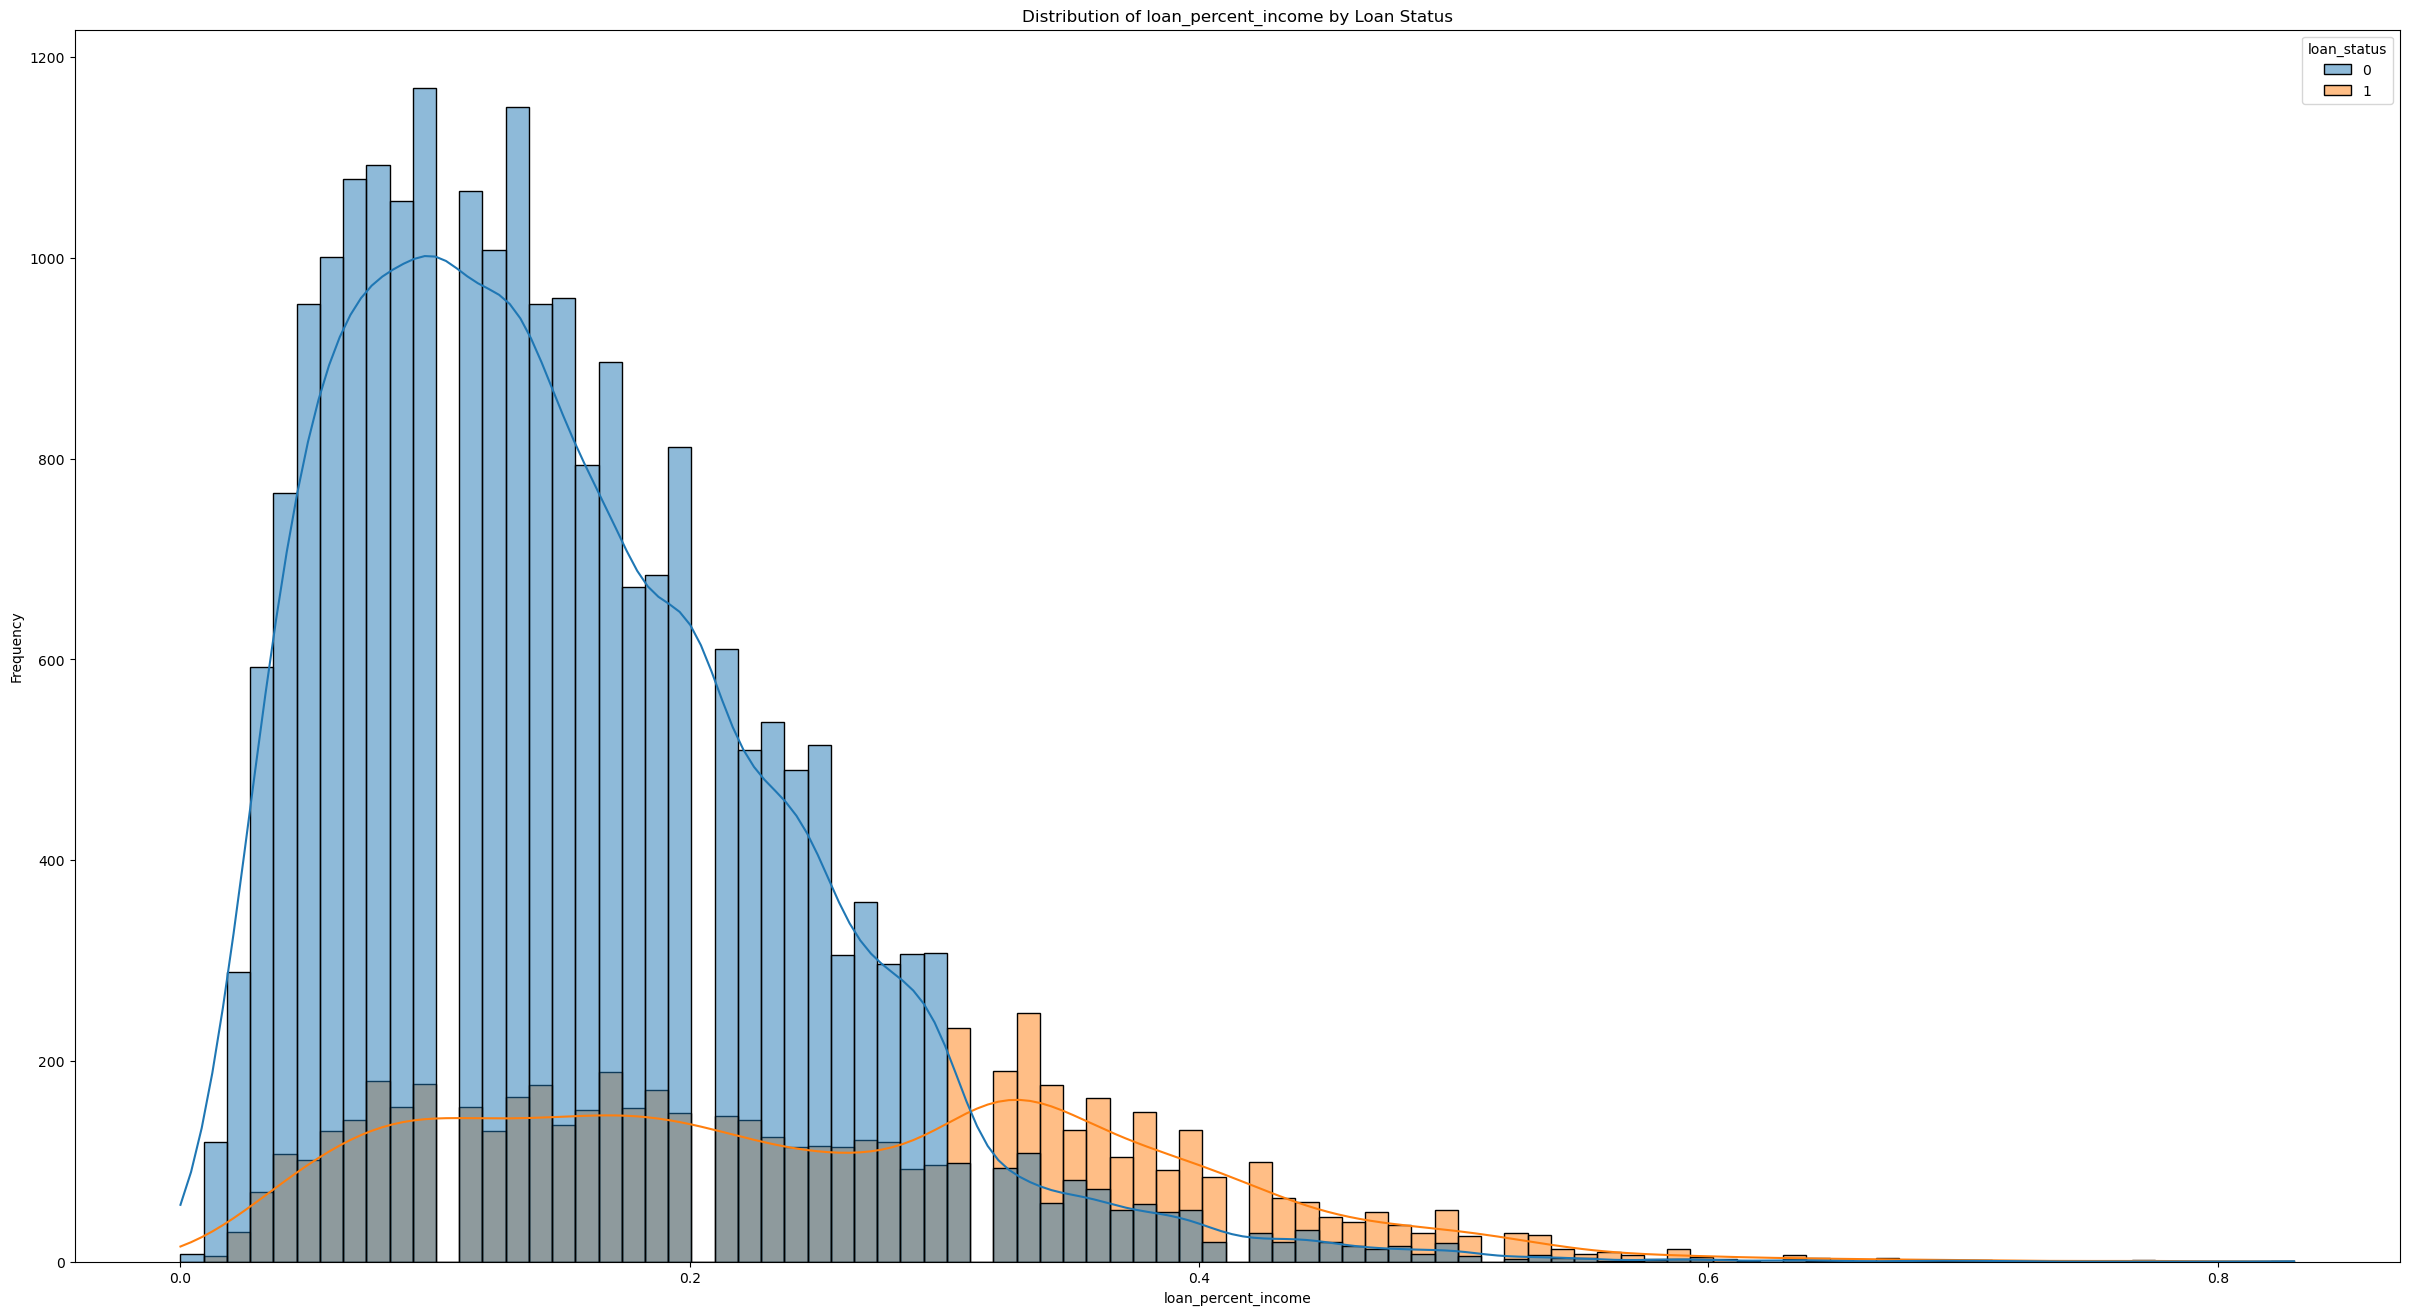

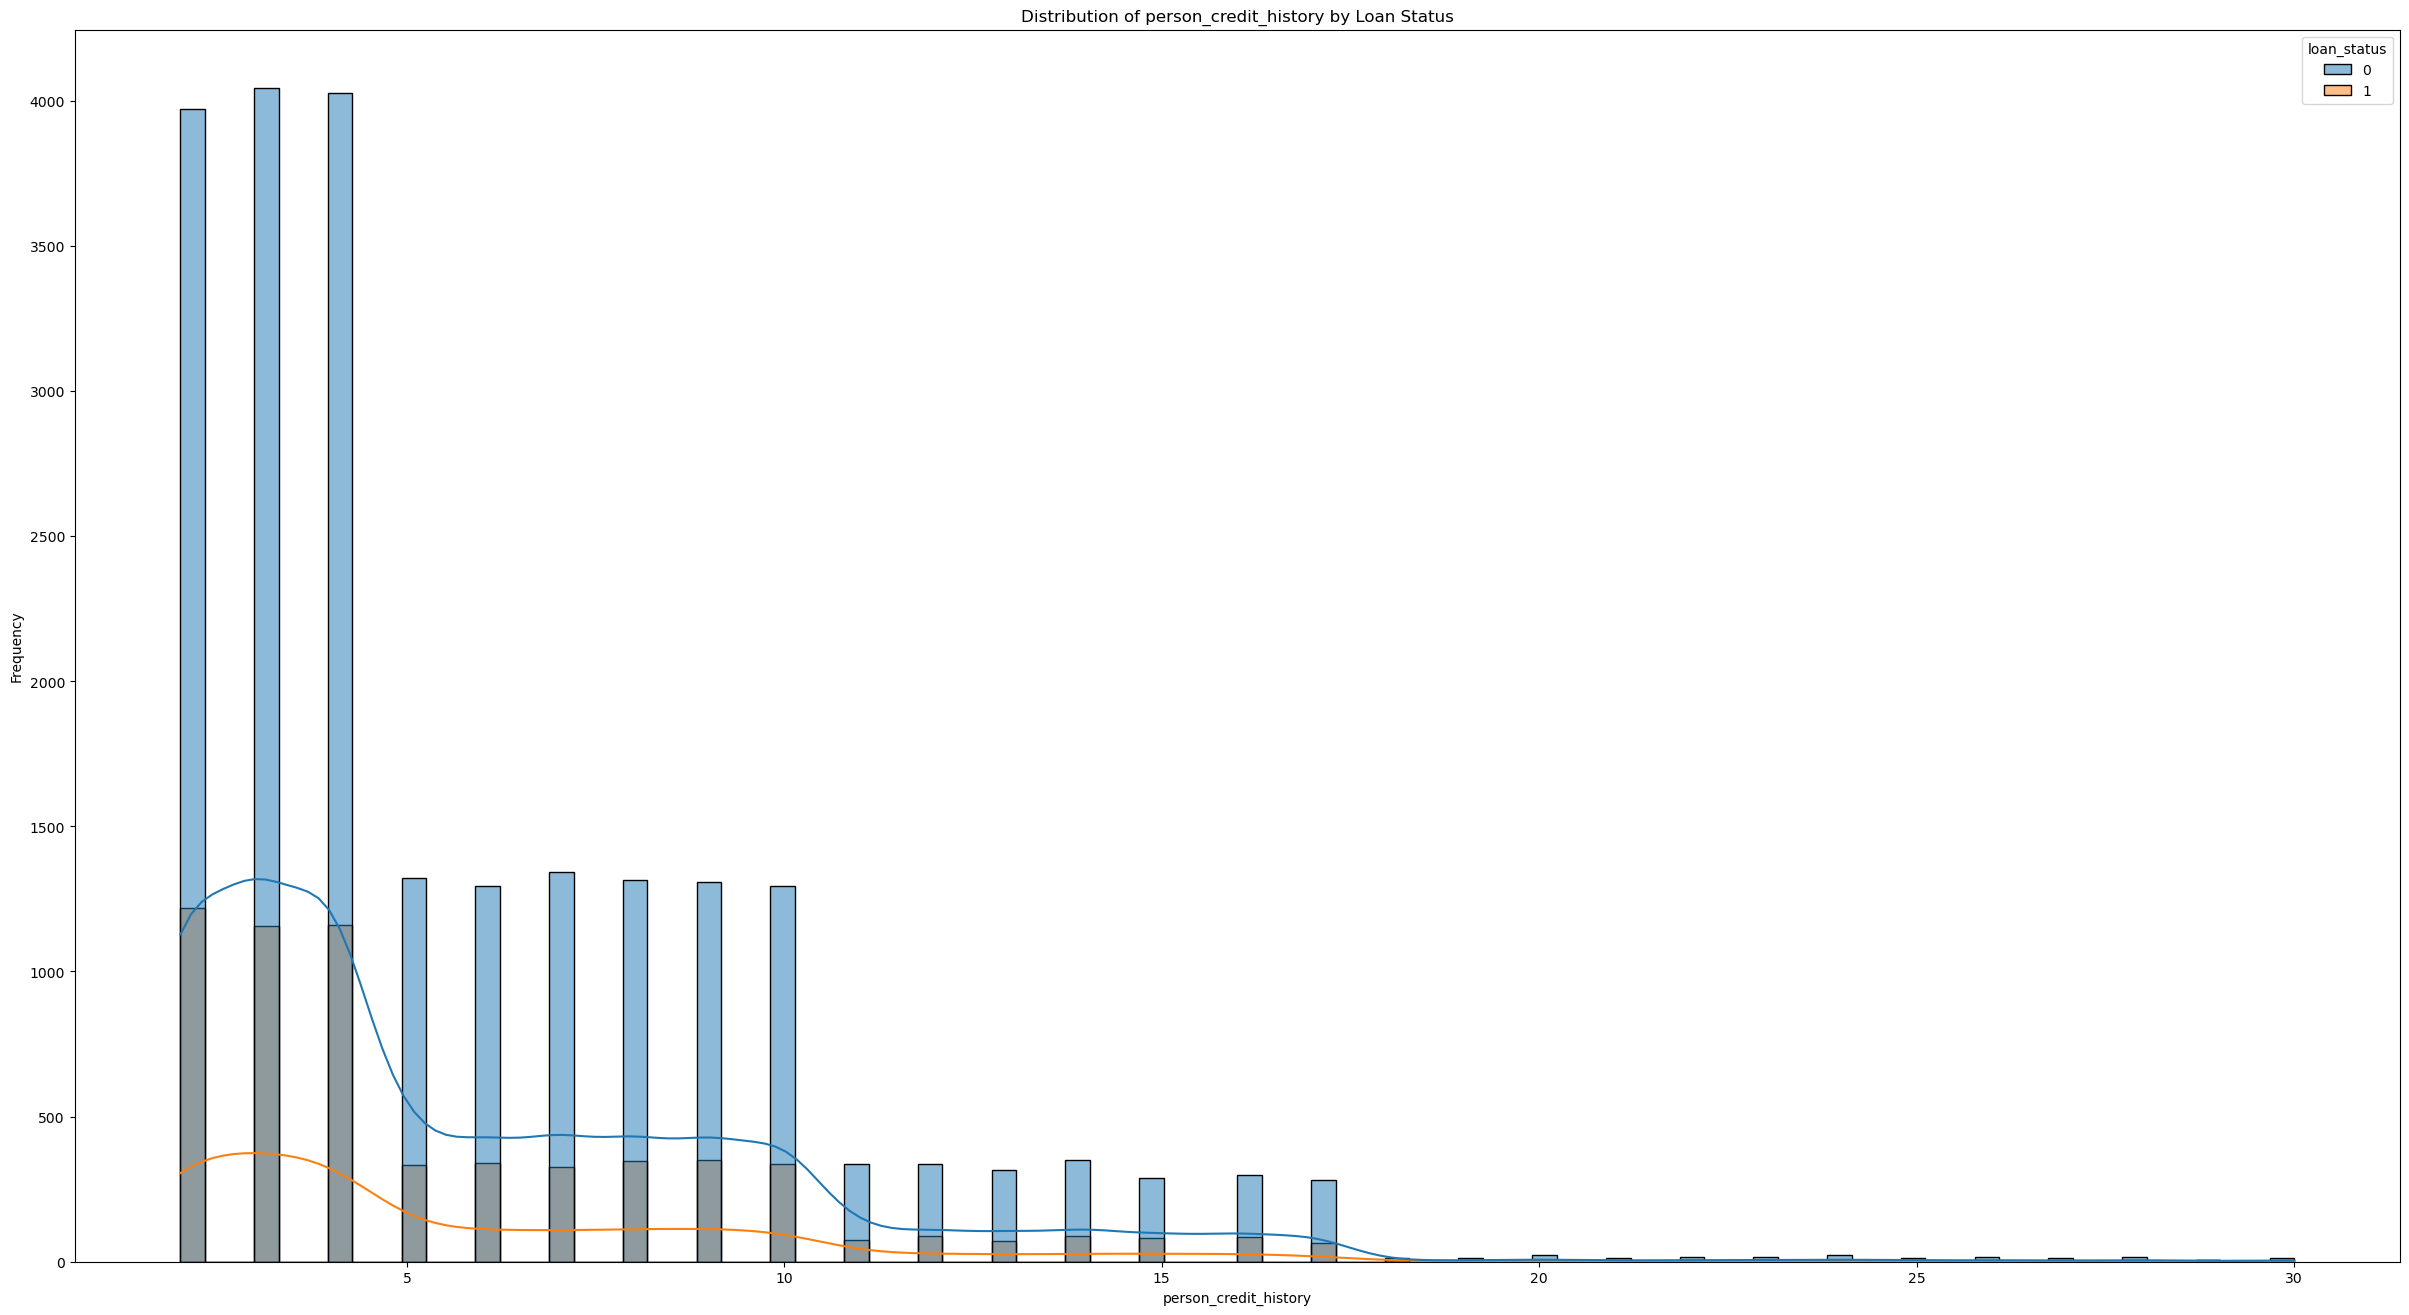

In [59]:
for feature in numerical_cols:
    plt.figure(figsize=(30, 16))
    sns.histplot(data=df, x=feature, hue='loan_status', kde=True)
    plt.title(f'Distribution of {feature} by Loan Status')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

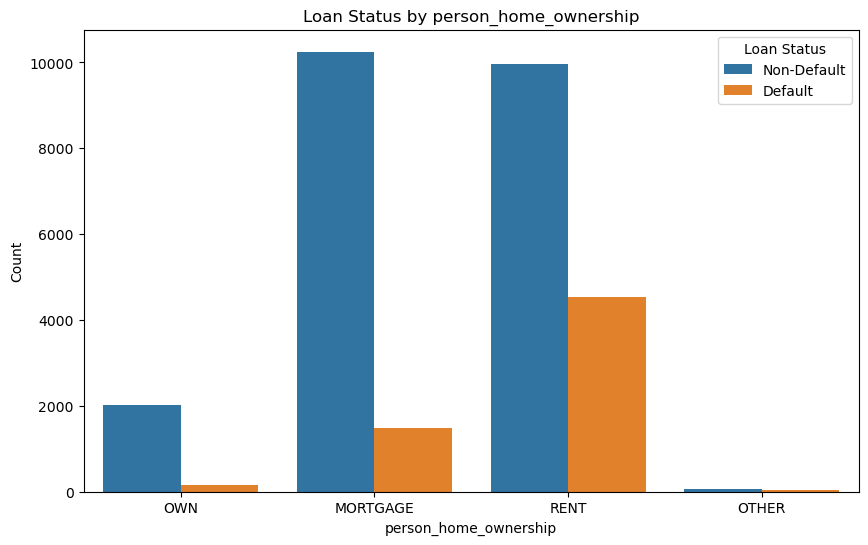

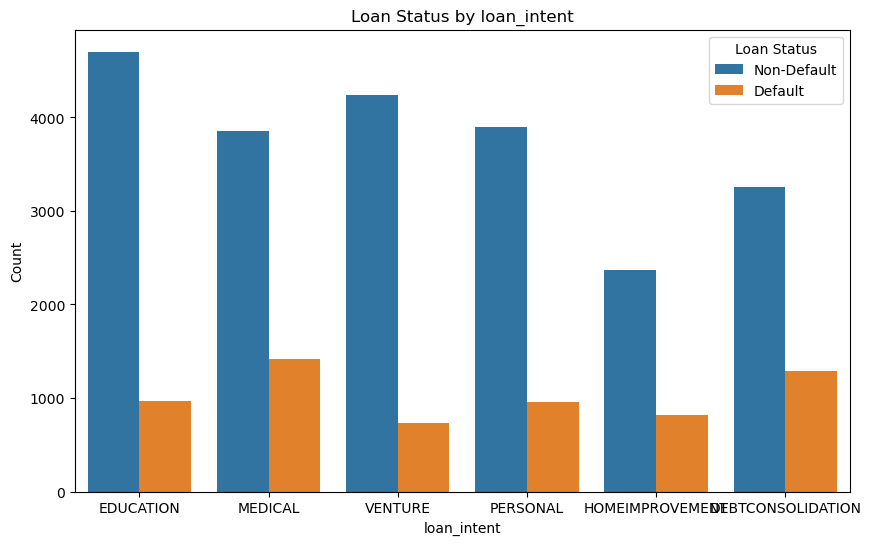

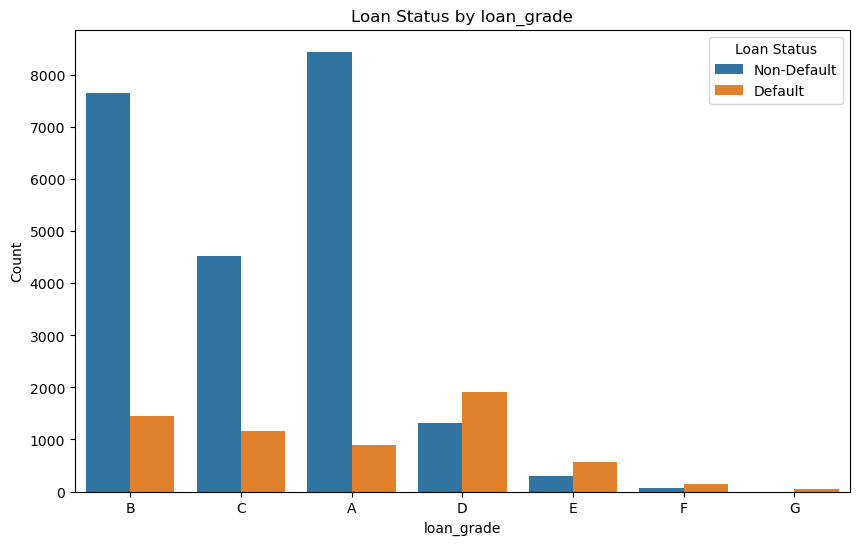

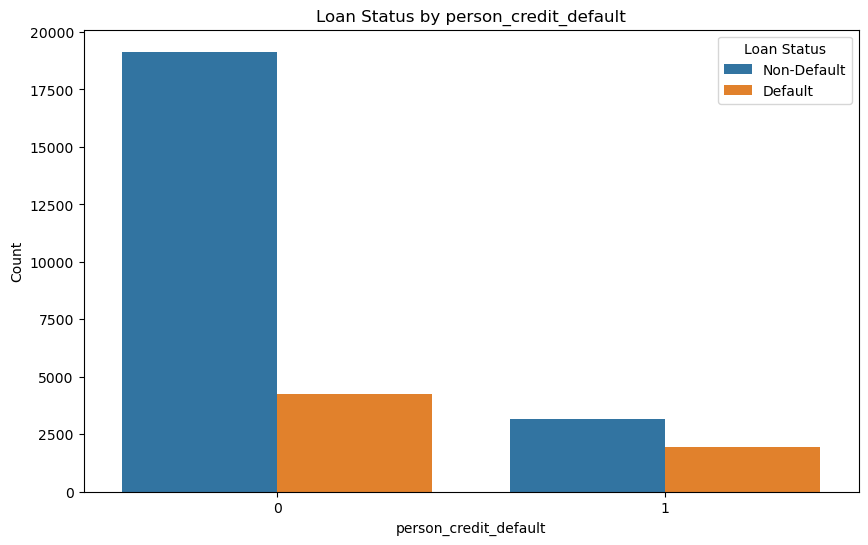

In [60]:
for feature in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=feature, hue='loan_status', data=df)
    plt.title(f'Loan Status by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(title='Loan Status', labels=['Non-Default', 'Default'])
    plt.show()

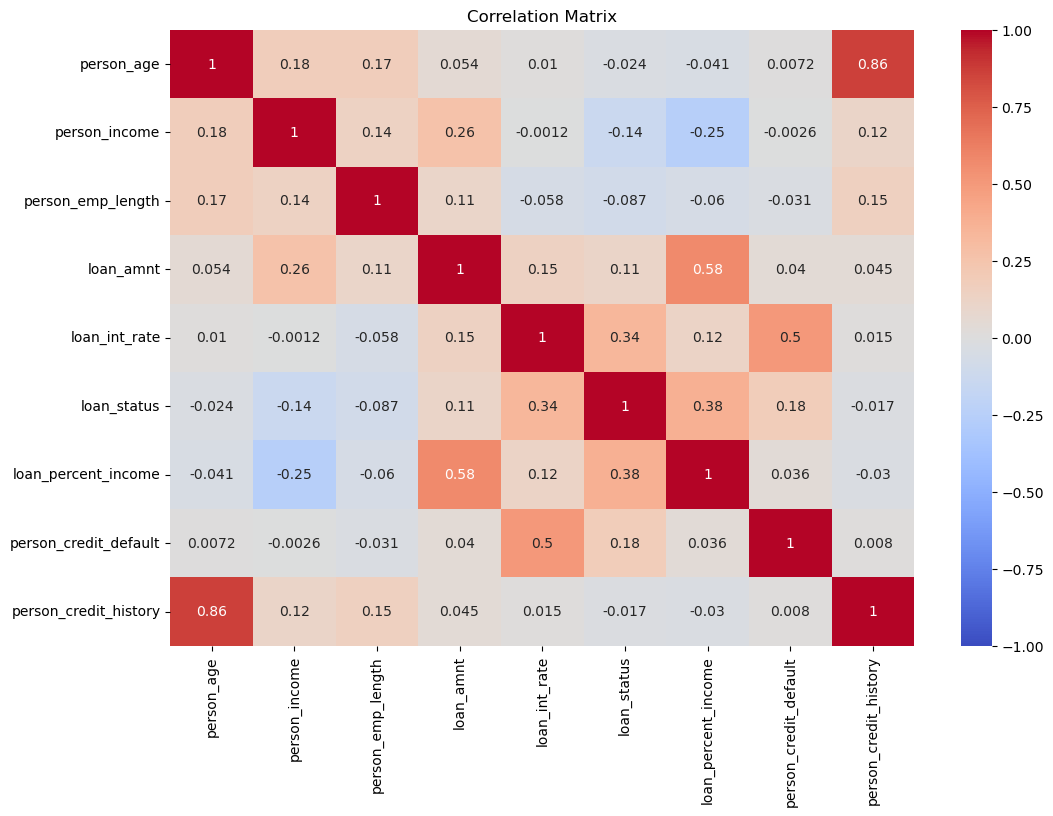

In [61]:
# Correlation Matrix
plt.figure(figsize=(12, 8))
numeric_data = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

Above correlation matrix shows a strong correlation between person age and person credit history (0.86)

In [182]:
# Encode categorical variables - converting categorical variables into numerical variables
label_encoder = LabelEncoder()


df['person_home_ownership'] = label_encoder.fit_transform(df['person_home_ownership'])
df['loan_intent'] = label_encoder.fit_transform(df['loan_intent'])
df['loan_grade'] = label_encoder.fit_transform(df['loan_grade'])

df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,person_credit_default,person_credit_history
1,21,9600,2,5.0,1,1,1000,11.14,0,0.10,0,2
2,25,9600,0,1.0,3,2,5500,12.87,1,0.57,0,3
3,23,65500,3,4.0,3,2,35000,15.23,1,0.53,0,2
4,24,54400,3,8.0,3,2,35000,14.27,1,0.55,1,4
5,21,9900,2,2.0,5,0,2500,7.14,1,0.25,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,0,1.0,4,2,5800,13.16,0,0.11,0,30
32577,54,120000,0,4.0,4,0,17625,7.49,0,0.15,0,19
32578,65,76000,3,3.0,2,1,35000,10.99,1,0.46,0,28
32579,56,150000,0,5.0,4,1,15000,11.48,0,0.10,0,26


In [183]:
for col in categorical_features:
    print(f"\nDistribution of categorical variable {col}:")
    print(df[col].value_counts())


Distribution of categorical variable person_home_ownership:
person_home_ownership
3    14497
0    11735
2     2174
1       93
Name: count, dtype: int64

Distribution of categorical variable loan_intent:
loan_intent
1    5670
3    5269
5    4968
4    4858
0    4547
2    3187
Name: count, dtype: int64

Distribution of categorical variable loan_grade:
loan_grade
0    9344
1    9094
2    5682
3    3242
4     869
5     209
6      59
Name: count, dtype: int64


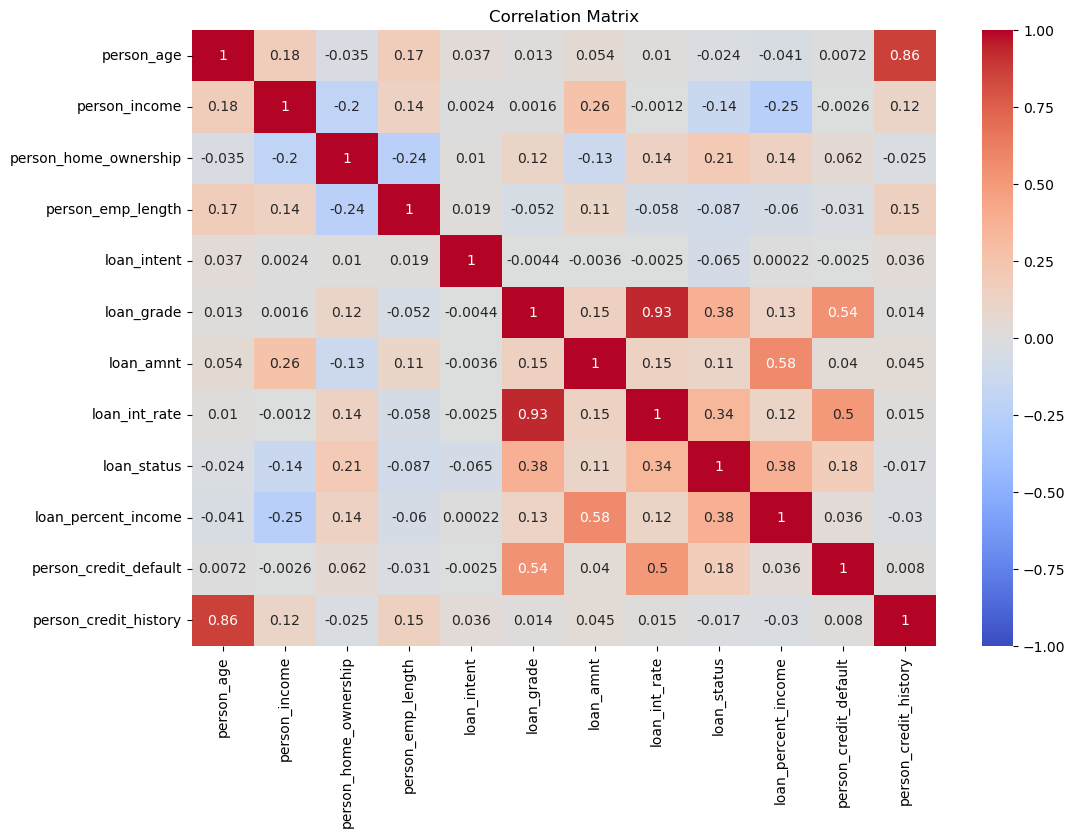

In [184]:
# Correlation Matrix
plt.figure(figsize=(12, 8))
numeric_data = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

Above correlation matrix shows a strong correlation between loan interest rate and loan grade (.93) in addition to the 
correlation between age and credit history as depicted earlier

Model 1 : created using all the variables, except the loan status, as the independent variables.

In [172]:
X = df.drop('loan_status', axis=1) 
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'X_train size {X_train.shape},X_test: {X_test.shape}, Y_train: {y_train.shape}, Y_test {y_test.shape}')


# MinMaxScaler for feature scaling 
scaler = MinMaxScaler().set_output(transform="pandas").fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)


X_train size (22799, 11),X_test: (5700, 11), Y_train: (22799,), Y_test (5700,)


In [173]:
X_train_sm = sm.add_constant(X_train_norm) 
model_sm = sm.Logit(y_train, X_train_sm)
result = model_sm.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.366310
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                22799
Model:                          Logit   Df Residuals:                    22787
Method:                           MLE   Df Model:                           11
Date:                Sun, 23 Jun 2024   Pseudo R-squ.:                  0.2996
Time:                        07:18:38   Log-Likelihood:                -8351.5
converged:                       True   LL-Null:                       -11924.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -4.1252      0.097    -42.379      0.000      -4.316      -3.

Above summary shows that age, income, credit default, credit history are not statistically significant

In [174]:
model = LogisticRegression(class_weight='balanced',random_state=50)

model.fit(X_train_norm, y_train)

y_pred = model.predict(X_test_norm)
print(classification_report(y_test, y_pred))

train_accuracy = accuracy_score(y_train, model.predict(X_train_norm))
test_accuracy = accuracy_score(y_test, model.predict(X_test_norm))
print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")

              precision    recall  f1-score   support

           0       0.93      0.78      0.85      4459
           1       0.49      0.78      0.61      1241

    accuracy                           0.78      5700
   macro avg       0.71      0.78      0.73      5700
weighted avg       0.83      0.78      0.79      5700

Training Accuracy: 0.7827097679722795
Testing Accuracy: 0.7782456140350877


In [175]:
confusion_table(y_pred, y_test)

Truth,0,1
Predicted,,
0,3462,267
1,997,974


In [176]:
print(f"Overall Test Accuracy and Error rate are {np.mean(y_pred == y_test):.3f}, {np.mean(y_pred != y_test):.3f}")

Overall Test Accuracy and Error rate are 0.778, 0.222


Model 2 : created using only the statistically significant variables, removing the others.

In [177]:
X = df.drop(['loan_status','person_age','person_income','person_credit_default','person_credit_history'], axis=1) 
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# MinMaxScaler for feature scaling 
scaler = MinMaxScaler().set_output(transform="pandas").fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)



In [178]:
X_train_sm = sm.add_constant(X_train_norm) 
model_sm = sm.Logit(y_train, X_train_sm)
result2 = model_sm.fit()
print(result2.summary())

Optimization terminated successfully.
         Current function value: 0.366451
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                22799
Model:                          Logit   Df Residuals:                    22791
Method:                           MLE   Df Model:                            7
Date:                Sun, 23 Jun 2024   Pseudo R-squ.:                  0.2993
Time:                        07:22:19   Log-Likelihood:                -8354.7
converged:                       True   LL-Null:                       -11924.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -4.0608      0.087    -46.655      0.000      -4.231      -3.

In [179]:
model = LogisticRegression(class_weight='balanced',random_state=50)

model.fit(X_train_norm, y_train)

y_pred2 = model.predict(X_test_norm)
print(classification_report(y_test, y_pred))

train_accuracy = accuracy_score(y_train, model.predict(X_train_norm))
test_accuracy = accuracy_score(y_test, model.predict(X_test_norm))
print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")

              precision    recall  f1-score   support

           0       0.93      0.78      0.85      4459
           1       0.49      0.78      0.61      1241

    accuracy                           0.78      5700
   macro avg       0.71      0.78      0.73      5700
weighted avg       0.83      0.78      0.79      5700

Training Accuracy: 0.7813061976402473
Testing Accuracy: 0.7770175438596492


In [180]:
confusion_table(y_pred2, y_test)

Truth,0,1
Predicted,,
0,3455,267
1,1004,974


In [181]:
print(f"Overall Test Accuracy and Error rate are {np.mean(y_pred2 == y_test):.3f}, {np.mean(y_pred2 != y_test):.3f}")

Overall Test Accuracy and Error rate are 0.777, 0.223


Model 3 : another model created by dropping interest rate because of its high correlation with the loan grade

In [185]:
X = df.drop(['loan_status','loan_int_rate'], axis=1) 
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'X_train size {X_train.shape},X_test: {X_test.shape}, Y_train: {y_train.shape}, Y_test {y_test.shape}')

scaler = MinMaxScaler().set_output(transform="pandas").fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)


X_train size (22799, 10),X_test: (5700, 10), Y_train: (22799,), Y_test (5700,)


In [186]:
X_train_sm = sm.add_constant(X_train_norm) 
model_sm = sm.Logit(y_train, X_train_sm)
result3 = model_sm.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.366430
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                22799
Model:                          Logit   Df Residuals:                    22787
Method:                           MLE   Df Model:                           11
Date:                Sun, 23 Jun 2024   Pseudo R-squ.:                  0.2996
Time:                        07:33:29   Log-Likelihood:                -8351.5
converged:                       True   LL-Null:                       -11924.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -4.1252      0.097    -42.379      0.000      -4.316      -3.

In [187]:
model = LogisticRegression(class_weight='balanced',random_state=50)

model.fit(X_train_norm, y_train)

y_pred3 = model.predict(X_test_norm)
print(classification_report(y_test, y_pred))

train_accuracy = accuracy_score(y_train, model.predict(X_train_norm))
test_accuracy = accuracy_score(y_test, model.predict(X_test_norm))
print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")

              precision    recall  f1-score   support

           0       0.93      0.78      0.85      4459
           1       0.49      0.78      0.61      1241

    accuracy                           0.78      5700
   macro avg       0.71      0.78      0.73      5700
weighted avg       0.83      0.78      0.79      5700

Training Accuracy: 0.7826220448265275
Testing Accuracy: 0.7782456140350877


In [188]:
confusion_table(y_pred3, y_test)

Truth,0,1
Predicted,,
0,3461,266
1,998,975


In [189]:
print(f"Overall Test Accuracy and Error rate are {np.mean(y_pred3 == y_test):.3f}, {np.mean(y_pred3 != y_test):.3f}")

Overall Test Accuracy and Error rate are 0.778, 0.222


All of the above logistic regression models have an accuracy of near 80%
Model 4: therefore, tried randomforest model which gave a testing accuracy score of > 93% and 100% for training data

In [192]:
X = df.drop(['loan_status','loan_int_rate'], axis=1) 
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'X_train size {X_train.shape},X_test: {X_test.shape}, Y_train: {y_train.shape}, Y_test {y_test.shape}')

scaler = MinMaxScaler().set_output(transform="pandas").fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

X_train size (22799, 10),X_test: (5700, 10), Y_train: (22799,), Y_test (5700,)


In [193]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

model = RandomForestClassifier(n_estimators=100, random_state = 42) 

model.fit(X_train_norm, y_train)

y_pred4 = model.predict(X_test_norm)
print(classification_report(y_test, y_pred))

train_accuracy = accuracy_score(y_train, model.predict(X_train_norm))
test_accuracy = accuracy_score(y_test, model.predict(X_test_norm))
print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")

              precision    recall  f1-score   support

           0       0.93      0.78      0.85      4459
           1       0.49      0.78      0.61      1241

    accuracy                           0.78      5700
   macro avg       0.71      0.78      0.73      5700
weighted avg       0.83      0.78      0.79      5700

Training Accuracy: 1.0
Testing Accuracy: 0.9315789473684211


In [194]:
confusion_table(y_pred4, y_test)

Truth,0,1
Predicted,,
0,4428,359
1,31,882


In [195]:
print(f"Overall Test Accuracy and Error rate are {np.mean(y_pred4 == y_test):.3f}, {np.mean(y_pred4 != y_test):.3f}")

Overall Test Accuracy and Error rate are 0.932, 0.068
